In [1]:
import os
import sys

import numpy as np
import pandas as pd
import math
from tqdm import tqdm

from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import collections as coll
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree

sys.path.append("../..")
import merge as merge
import extension as ext
import zroutlier as zro
import free_hits as free
import track_score as score2

%matplotlib inline

In [2]:
TRAIN_PATH = '../../../input/train_1'
event_id = 1029

In [3]:

event_prefix = 'event00000' + str(event_id)
hits, cells, particles, truth = load_event(os.path.join(TRAIN_PATH, event_prefix))

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event_prefix, mem_bytes / 2**20))

event000001029 memory usage 16.61 MB


In [4]:
#labels_helix1 = pd.read_csv('../../best_csvs12/event_' + str(event_id) + '_labels_train_helix1.csv').label.values
#labels_helix2 = pd.read_csv('../../best_csvs12/event_' + str(event_id) + '_labels_train_helix2.csv').label.values
#labels_helix1a = pd.read_csv('../../event_' + str(event_id) + '_labels_train_helix1_phase1_dbscan1.csv').label.values
#labels_helix2 = pd.read_csv('../../event_' + str(event_id) + '_labels_train_helix1_phase1_dbscan1_processed.csv').label.values
labels_helix1 = pd.read_csv('../../event_' + str(event_id) + '_labels_train_helix1.csv').label.values
labels_helix2 = pd.read_csv('../../event_' + str(event_id) + '_labels_train_helix2.csv').label.values
#labels_helix3 = pd.read_csv('../../best_csvs12/event_' + str(event_id) + '_labels_train_helix3.csv').label.values

In [5]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

def score_one_submission(event_id, hits, labels, truth):
    submission = create_one_event_submission(event_id, hits, labels)
    score = score_event(truth, submission)
    print("Score for event %d: %.32f" % (event_id, score))

In [ ]:
#labels_helix1_filter = merge.remove_outliers(labels_helix1, hits, print_counts=True)
#labels_helix2_filter = merge.remove_outliers(labels_helix2, hits, print_counts=True)
labels_helix1_filter = remove_outliers_zr(labels_helix1, hits)
labels_helix1_filter = remove_outliers_zr(labels_helix1_filter, hits)
labels_helix1_filter = remove_outliers_zr(labels_helix1_filter, hits)
labels_helix2_filter = remove_outliers_zr(labels_helix2, hits)
labels_helix2_filter = remove_outliers_zr(labels_helix2_filter, hits)
labels_helix2_filter = remove_outliers_zr(labels_helix2_filter, hits)
#labels_helix3_filter = merge.remove_outliers(labels_helix3, hits, print_counts=True)

In [ ]:
labels_merged = merge.heuristic_merge_tracks(labels_helix1_filter, labels_helix2_filter, overwrite_limit=3)
#labels_merged = merge.heuristic_merge_tracks(labels_merged, labels_helix3_filter)
one_submission = create_one_event_submission(event_id, hits, labels_merged)
score = score_event(truth, one_submission)
print("Merged score for event %d: %.8f" % (event_id, score))

In [ ]:
labels_helix1_filter2 = remove_outliers_zr(labels_helix1, hits)
labels_helix1_filter3 = remove_outliers_zr(labels_helix1_filter2, hits)
#labels_helix1_filter4 = safe_outlier_removal(labels_helix1_filter3, hits, truth, debug=False)
labels_helix1_filter4 = remove_outliers_zr(labels_helix1_filter3, hits)
labels_helix1_filter5 = merge.remove_outliers(labels_helix1_filter4, hits, print_counts=True)
labels_helix2_filter2 = remove_outliers_zr(labels_helix2, hits)
labels_helix2_filter3 = remove_outliers_zr(labels_helix2_filter2, hits)
labels_helix2_filter4 = remove_outliers_zr(labels_helix2_filter3, hits)
#labels_helix2_filter4 = safe_outlier_removal(labels_helix2_filter3, hits, truth, debug=False)
labels_helix2_filter5 = merge.remove_outliers(labels_helix2_filter4, hits, print_counts=True)
labels_merged = merge.heuristic_merge_tracks(labels_helix1_filter5, labels_helix2_filter5, overwrite_limit=3)
one_submission = create_one_event_submission(event_id, hits, labels_merged)
score = score_event(truth, one_submission)
print("Merged score for event %d: %.8f" % (event_id, score))

In [ ]:
labels_helix1_filter2 = safe_outlier_removal(labels_helix1, hits, truth, find_all=True, debug=False)
#labels_helix1_filter2 = safe_outlier_removal(labels_helix1_filter2, hits, truth, debug=False)
#labels_helix2_filter2 = safe_outlier_removal(labels_helix2, hits, truth, debug=False)
#labels_helix2_filter2 = safe_outlier_removal(labels_helix2_filter2, hits, truth, debug=False)
#labels_helix2_filter2 = safe_outlier_removal(labels_helix2_filter2, hits, truth, debug=False)
#labels_helix1_filter3 = safe_outlier_removal(labels_helix1_filter2, hits, truth)
# 321 v 167, 394 v 199 for find_all
# 2143 v 407, 2634 v 512 for find_all 

In [ ]:
def find_circle_curvature(x1, y1, x2, y2, x3, y3):
    x01 = d01.x();
    y01 = d01.y();
    x12 = d12.x();
    y12 = d12.y();
    x02 = x01 + x12;
    y02 = y01 + y12;
    # length of the triangle sides
    a = std::hypot(x12, y12);
    b = std::hypot(x02, y02);
    c = std::hypot(x01, y01);
    # 2 * (signed) area of the triangle
    k = (x02 * y01 - x01 * y02);
    # radius = product of side lengths / 4 times triangle area
    return (2 * k) / (a * b * c);


def estimate_circle_d0(p0, phi0, kappa):
    x0_sin = p0.x * std::sin(phi0)
    y0_cos = p0.y * std::cos(phi0)
    return (y0_cos - x0_sin) + 0.5 * kappa * (p0.x**2 + p0.y**2)
        + 0.5 * kappa * (x0_sin**2 + y0_cos**2 - 2 * x0_sin * y0_cos);

# Estimate the z position at vanishing transverse radius.
def estimate_z_helix_z0(p0, theta):
    return p0.z - std::hypot(p0.x, p0.y * std::tan(M_PI_2 - theta);

namespace Acts {
namespace Seeding {

  struct HelixSeedConfig
  {
    double rangePhi1     = 0.2;  // search range in phi at layer 1
    double rangePhi2     = 0.2;  // search range in phi at layer 2
    double maxDeltaTheta = 0.1;  // cut on difference in theta between doublets
  };

  /// Find 3-point seeds with a combinatorial algorithm.
  template <typename Identifier>
  void
  findHelixSeeds(const HelixSeedConfig&               cfg,
                 const BarrelSpacePoints<Identifier>& barrel0,
                 const BarrelSpacePoints<Identifier>& barrel1,
                 const BarrelSpacePoints<Identifier>& barrel2,
                 TrackSeeds3<Identifier>&             seeds);

}  // namespace Seeding
}  // namespace Acts

template <typename Identifier>
inline void
Acts::Seeding::findHelixSeeds(const HelixSeedConfig&               cfg,
                              const BarrelSpacePoints<Identifier>& barrel0,
                              const BarrelSpacePoints<Identifier>& barrel1,
                              const BarrelSpacePoints<Identifier>& barrel2,
                              TrackSeeds3<Identifier>&             seeds)
{
  for (const auto& p0 : barrel0.points) {
    for (const auto& p1 : barrel1.rangeDeltaPhi(p0.phi(), cfg.rangePhi1)) {
      Vector3D d01     = p1.position() - p0.position();
      double   theta01 = d01.theta();
      // Acts::Vector3D at2
      //     = detail::calcLineCircleIntersection(p0, d01, barrel2.radius);
      for (const auto& p2 : barrel2.rangeDeltaPhi(p1.phi(), cfg.rangePhi2)) {
        Vector3D d12     = p2.position() - p1.position();
        double   theta12 = d12.theta();

        if (cfg.maxDeltaTheta < std::abs(theta12 - theta01)) continue;

        double kappa = detail::calcCircleCurvature(d01, d12);
        // initial direction correction due to curvature, use
        //   chord = 2 * radius * sin(propagation angle / 2)
        // and assume sin(x) = x
        double phi01 = d01.phi() - d01.head<2>().norm() * kappa / 2;
        // track parameters defined at the first space point
        seeds.emplace_back(phi01, theta01, kappa, p0, p1, p2);
      }
    }
  }
}


In [6]:
labels_helix1_filter = merge.remove_outliers(labels_helix1, hits, print_counts=True)
labels_helix2_filter = merge.remove_outliers(labels_helix2, hits, print_counts=True)
labels_merged = merge.heuristic_merge_tracks(labels_helix1_filter, labels_helix2_filter, hits, overwrite_limit=6)
score_one_submission(event_id, hits, labels_merged, truth)

Total removed due to bad volumes: 0
Total removed due to bad zr values: 1079
Total removed due to bad dimensions: 0
Total removed due to duplicate zs: 2172
Total removed due to bad slopes: 949
Total removed small tracks (<2) hits: 1084
Total removed due to bad volumes: 0
Total removed due to bad zr values: 853
Total removed due to bad dimensions: 0
Total removed due to duplicate zs: 2256
Total removed due to bad slopes: 934
Total removed small tracks (<2) hits: 100
Score for event 1029: 0.69792186236579401015234225269523


In [ ]:
#labels_helix1_filter = merge.remove_outliers(labels_helix1, hits, print_counts=True)
#labels_helix2_filter = merge.remove_outliers(labels_helix2, hits, print_counts=True)
#labels_helix1_filter2 = assign_free_hits(labels_helix1_filter, hits)
#labels_helix2_filter2 = assign_free_hits(labels_helix2_filter, hits)
labels_merged = merge.heuristic_merge_tracks(labels_helix1_filter, labels_helix2_filter, overwrite_limit=3)
one_submission = create_one_event_submission(event_id, hits, labels_merged)
score = score_event(truth, one_submission)
print("Merged score for event %d: %.8f" % (event_id, score))
labels_merged2 = free.assign_free_hits(labels_merged, hits)
one_submission = create_one_event_submission(event_id, hits, labels_merged2)
score = score_event(truth, one_submission)
print("Merged free-hit score for event %d: %.8f" % (event_id, score))
#labels_merged2 = np.copy(labels_merged)
#labels_merged2 = assign_free_hits(labels_merged2, hits)
#one_submission = create_one_event_submission(event_id, hits, labels_merged2)
#score = score_event(truth, one_submission)
#print("Merged score for event %d: %.8f" % (event_id, score))
# zr:     0.68239816, 0.68255797, 0.68265559
# crs:    0.68239816, 0.68264529, 0.68269281
# crs+zr: 0.68239816, 0.68454839, 0.68476117  (rem 2,3,4)
# crs+zr: 0.68239816, 0.68396086, 0.68419647  (rem 1,2,3)
# crs+zr: 0.68239816, 0.68471627, 0.68479848  (rem 2,3, no short track favoring)
# crs+zr: 0.68239816, 0.68432189, 0.68465735, 0.68476141  (rem 1,2,3, no short track favoring)

In [7]:
hits['z_abs'] = hits.z.abs()
hits['r'] = np.sqrt(hits.x**2+hits.y**2)
hits['zr'] = hits['z'] / hits['r']
hits['azr'] = np.arctan2(hits['z'], hits['r'])

/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice.
/anaconda3/envs/trackml/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Found: 2014
straight tracks: [4, 7, 16, 19, 21, 24, 25, 35, 36, 37, 40, 48, 50, 52, 53, 54, 55, 57, 59, 60, 61, 62, 64, 76, 78, 82, 89, 90, 91, 93, 94, 95, 98, 99, 100, 102, 103, 104, 108, 111, 112, 113, 118, 120, 123, 124, 130, 131, 132, 133, 134, 135, 137, 142, 143, 144, 151, 153, 154, 155, 161, 162, 167, 169, 170, 171, 172, 173, 178, 180, 181, 184, 189, 191, 193, 194, 196, 199, 200, 201, 203, 210, 212, 213, 214, 216, 225, 226, 227, 228, 231, 232, 233, 234, 235, 236, 239, 241, 248, 249, 250, 251, 252, 255, 257, 264, 273, 275, 276, 277, 279, 286, 291, 293, 294, 295, 296, 308, 309, 310, 312, 313, 314, 315, 320, 323, 324, 328, 330, 331, 332, 333, 335, 343, 345, 349, 350, 351, 352, 353, 354, 357, 374, 376, 377, 378, 379, 382, 383, 384, 385, 404, 405, 406, 407, 408, 419, 420, 422, 424, 425, 437, 438, 441, 443, 456, 457, 458, 459, 461, 463, 464, 465, 466, 467, 468, 471, 478, 490, 492, 493, 495, 496, 502, 518, 521, 541, 542, 543, 544, 545, 546, 547, 549, 551, 564, 565, 566, 567, 568, 569, 5

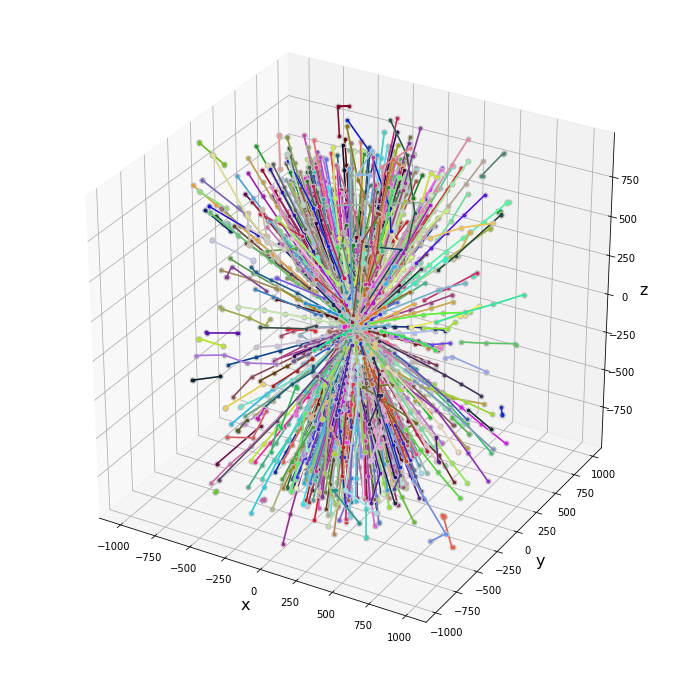

In [11]:
#labels_helix1_filter
labels = np.copy(labels_merged)
tracks = np.unique(labels)
straight_tracks = []
straight_ids = []
for track in tracks:
    if track == 0: continue
    (is_straight, track_dims) = is_straight_track(track, labels, hits)
    if is_straight:
        straight_tracks.append(track_dims)
        straight_ids.append(track)

print('Found: ' + str(len(straight_tracks)))
if len(straight_tracks) > 10:
    draw_prediction_xyz(straight_tracks, straight_tracks)
print('straight tracks: ' + str(straight_ids))

In [ ]:

print('straight tracks: ' + str(straight_ids))

In [12]:
straight_ids_equal = []
straight_ids_unequal = []
for straight_track in straight_ids:
    if matches_straight_truth_track(straight_track, labels, hits, truth):
        straight_ids_equal.append(straight_track)
    else:
        straight_ids_unequal.append(straight_track)

print('Num equal to ground truth: ' + str(len(straight_ids_equal)))
print('Num differences: ' + str(len(straight_ids_unequal)))
print('Differences: ' + str(straight_ids_unequal))

Num equal to ground truth: 1802
Num differences: 212
Differences: [16, 21, 24, 50, 52, 53, 93, 103, 104, 118, 123, 130, 144, 171, 180, 194, 199, 200, 210, 213, 226, 232, 233, 241, 248, 277, 296, 343, 353, 357, 374, 376, 384, 406, 422, 457, 490, 544, 545, 551, 590, 603, 622, 657, 684, 693, 727, 757, 796, 835, 871, 949, 952, 963, 1047, 1050, 1129, 1132, 1176, 1180, 1225, 1227, 1242, 1246, 1247, 1249, 1296, 1297, 1300, 1344, 1345, 1347, 1349, 1350, 1352, 1415, 1457, 1479, 1521, 1534, 1576, 1583, 1644, 1645, 1653, 1711, 1754, 1833, 1838, 1909, 1955, 2023, 2133, 2188, 2457, 2458, 2522, 2637, 2721, 2810, 2836, 2988, 3058, 3063, 3064, 3107, 3213, 3267, 3505, 3561, 3675, 3688, 3790, 3798, 3800, 3808, 3856, 3863, 3929, 3934, 4101, 4117, 4156, 4170, 4179, 4233, 4235, 4269, 4278, 4322, 4327, 4373, 4488, 4491, 4503, 4504, 4558, 4613, 4674, 4774, 4785, 4926, 4958, 4959, 4992, 5022, 5126, 5127, 5129, 5134, 5159, 5183, 5196, 5222, 5223, 5225, 5227, 5231, 5258, 5306, 5386, 5437, 5566, 5569, 5597, 5601

In [ ]:
track_id = 2988
lengthen_straight_track(track_id, labels, hits, truth)
#labels_straightx = straight_track_extension(track_id, labels, hits)
# 21.988119
# 21.968767
# ??? --> 21.949 --> wrong one :(

In [130]:
#+ Track: 357 taking un-assigned hits, ixes: [4605, 4606, 4556, 4581], old tracks: [3808    0 3808    0]
#+ Track: 357, zr_exp: -16.6945457458, assigning dup-z hits: [4606, 4581]
#- Track: 544, zr_exp: -15.1924648285, assigning hits: [12667] from tracks: [0]
#+ Track: 545 taking un-assigned hits, ixes: [3285, 3294, 3232, 3239], old tracks: [4056    0    0 4056]
#+ Track: 545, zr_exp: -10.2328510284, assigning dup-z hits: [3294, 3232]
# --> 2 layer-4 hits, one very wrong, can detect it and replace with proper one?
#+ Track: 551, zr_exp: -14.0582380295, assigning hits: [1138] from tracks: [58]
#+ Track: 727 taking un-assigned hits, ixes: [10952, 10974, 10875, 10890, 10994, 11022], old tracks: [   0 3173 3173    0    0 3173]
#+ Track: 727, zr_exp: -17.5386199951, assigning dup-z hits: [10952, 10890, 10994]
#+ Track: 727 taking un-assigned hits, ixes: [13608, 13627, 13578, 13579, 13686, 13699], old tracks: [3173    0 3173    0    0 3173]
#+ Track: 727, zr_exp: -17.5334234238, assigning dup-z hits: [13627, 13579, 13686]
#+ Track: 2721, zr_exp: -11.8737044334, assigning hits: [12645 12549] from tracks: [0 0]
#+ Track: 3808, zr_exp: -16.6469669342, assigning hits: [1155] from tracks: [0]
#+ Track: 4179 taking un-assigned hits, ixes: [4668, 4678], old tracks: [   0 1967]
#+ Track: 4179, zr_exp: -12.7618861198, assigning dup-z hits: [4668]
#+ Track: 4179 taking un-assigned hits, ixes: [6916, 6922, 6848, 6860], old tracks: [1967    0 1967    0]
#+ Track: 4179, zr_exp: -12.7445468903, assigning dup-z hits: [6922, 6860]
#+ Track: 4785, zr_exp: -15.1713085175, assigning hits: [7386 7453] from tracks: [0 0]
#+-Track: 5134, zr_exp: -13.9130077362, assigning hits: [8043 8099] from tracks: [0 0]
# --> assigned 2 correct tracks, but did not get layer 12 hits (zr changes direction here). Look for zr between 2 layers?
#+-Track: 5196 taking un-assigned hits, ixes: [5993, 6008, 5923, 5924, 5941, 5946], old tracks: [1245    0    0 1245    0 1245]
#+-Track: 5196, zr_exp: -19.310918808, assigning dup-z hits: [6008, 5923, 5941]
# --> 2 out of 3 hits correct, taken from track-0. Correct hit was assigned to a different track already.
#+ Track: 5601, zr_exp: -16.1955623627, assigning hits: [1204] from tracks: [5763]
#- TODO! Track: 5645 cannot take hits, more work needed, ixes: [966, 968], old tracks: [ 597 2684]
#- Track: 5645, zr_exp: -12.8688583374, assigning dup-z hits: [929]
#+-Track: 5849, zr_exp: -14.1198029518, assigning hits: [12218 12179] from tracks: [7225 7225]
#+-Track: 5849, zr_exp: -14.1306371689, assigning hits: [14919 14855] from tracks: [13478 13478]
# --> track had one layer-10 hit, there is another layer 10 hit that we could find though.
#+ Track: 5956, zr_exp: -25.7599747976, assigning hits: [9085 9022] from tracks: [5127 5127]
#+ Track: 6040, zr_exp: -16.5139541626, assigning hits: [6100 6159] from tracks: [0 0]
#+ Track: 6040, zr_exp: -16.5144262314, assigning hits: [4043 4105] from tracks: [0 0]
#+ Track: 6040 taking un-assigned hits, ixes: [2279, 2304], old tracks: [2469    0]
#+ Track: 6040, zr_exp: -16.5270385742, assigning dup-z hits: [2304]
#+ Track: 6576 taking un-assigned hits, ixes: [7379, 7401], old tracks: [   0 1959]
#+ Track: 6576, zr_exp: -13.4632180532, assigning dup-z hits: [7379]
#+ Track: 6576 taking un-assigned hits, ixes: [5095, 5114], old tracks: [   0 1959]
#+ Track: 6576, zr_exp: -13.3664617538, assigning dup-z hits: [5095]
#+ Track: 6576, zr_exp: -13.3223991394, assigning hits: [3152] from tracks: [0]
#+ Track: 6576, zr_exp: -13.2972021103, assigning hits: [1519] from tracks: [0]
#+ Track: 6576, zr_exp: -13.2283744812, assigning hits: [200 165] from tracks: [0 0]
#-Track: 6624, zr_exp: -12.3436260223, assigning hits: [7194] from tracks: [3169]
# --> odd, no layer 10 in this track, we stole hit from another track (3169)
#+Track: 6624, zr_exp: -12.4289531708, assigning hits: [9829] from tracks: [0]
#+ Merge tracks [6625, 10910] allowed, matching volume [7] and non-overlapping adjacent layers: [ 8 10 12 14], [2 4 6]
#+ Track: 6625, zr_exp: -18.0581417084, assigning hits: [ 262 1658 3317 3376]
#+ Track: 7121, zr_exp: -10.2453260422, assigning hits: [728 758] from tracks: [8235 8235]
#+-Track: 7121, zr_exp: -10.5580883026, assigning hits: [11223 11136] from tracks: [12891   144]
# --> 11136 wrongly assigned
#+ Track: 7121, zr_exp: -10.5283002853, assigning hits: [13897 13971] from tracks: [12620 12620]
# --> can merge with track from volume 12, layers 2,4
#+ Track: 12302, zr_exp: -11.2988538742, assigning hits: [7925] from tracks: [0]
#- Track: 12302, zr_exp: -11.2662286758, assigning hits: [10524] from tracks: [6479]
# --> track only goes to layer 10, should not have extended to layer 12
#+-TODO! Track: 15707 cannot take hits, more work needed, ixes: [9471, 9472, 9512, 9516], old tracks: [  603 20068   603 20068]
#+-Track: 15707, zr_exp: -16.6653022766, assigning dup-z hits: [9417]
# --> assigning 9417 was correct, should have stolen [9471, 9512] as well
#+-Track: 18101, zr_exp: -8.26735210419, assigning hits: [14329] from tracks: [4439]
# --> could have extended from 7.4 into 12.6, and from 7.14 to 8.2



track_id = 18101
#graph_my_track(track_id, labels, hits)
lengthen_straight_track(track_id, labels, hits, truth)
labels_straightx = straight_track_extension(track_id, labels, hits)

Detected track: [ 2559  4403  6543  9009 11645]
Truth track:    [ 2559  4403  6543  9009 11645 14329 15570 59364]
               x           y       z        zr  volume_id  layer_id
2559   23.247400  154.893005 -1298.0 -8.287160          7         4
4403   18.144899  131.343002 -1098.0 -8.281140          7         6
6543   14.874600  114.775002  -958.0 -8.277541          7         8
9009   11.961000   98.129700  -818.0 -8.274665          7        10
11645   9.632670   83.839600  -698.0 -8.271008          7        12
               x           y            z        zr  volume_id  layer_id
59364  49.655998  254.612000 -2148.500000 -8.282290         12         6
2559   23.247400  154.893005 -1298.000000 -8.287160          7         4
4403   18.144899  131.343002 -1098.000000 -8.281140          7         6
6543   14.874600  114.775002  -958.000000 -8.277541          7         8
9009   11.961000   98.129700  -818.000000 -8.274665          7        10
11645   9.632670   83.839600  -698.00000

In [ ]:
#lengthen_straight_track(18, labels, hits, truth)
possible_matches = hits.loc[(hits['zr'] > 25.25) & (hits['zr'] < 25.35) & (hits['volume_id'] == 9) & (hits['layer_id'] == 6)]
px1 = possible_matches[['x','y', 'z', 'zr', 'volume_id', 'layer_id']]
print(px1)
#48855 -27.366800  17.225401   817.5  25.280945          9         6
#49002 -27.362101  17.259899   818.0  25.285137          9         6  25.288
#48928 -27.522600  17.305700   822.5  25.298941          9         6
#51147 -32.477798  19.420700   957.5  25.302980          9         8          0.020
#51276 -32.487801  19.437099   958.0  25.304823          9         8  25.308
#51224 -32.635700  19.500700   962.5  25.316973          9         8
#53173 -37.587700  21.615101  1097.5  25.311626          9        10          0.005
#53258 -37.613602  21.614401  1098.0  25.310255          9        10  25.313
#53208 -37.779999  21.656300  1102.5  25.317593          9        10          0.019
#54913 -44.953602  24.600599  1298.0  25.329466          9        12  25.332
#54870 -45.099701  24.675800  1302.5  25.336063          9        12          0.023
#56306 -52.273998  27.524599  1498.0  25.356438          9        14  25.355
#56281 -52.442101  27.591801  1502.5  25.355331          9        14

# Possible ones:
#48144  23.423700  22.537201  822.5  25.303558          9         6
#48215  23.288200  22.455200  818.0  25.285286          9         6
#48257  23.405001  22.547501  822.0  25.293100          9         6
#48855 -27.366800  17.225401  817.5  25.280945          9         6
#48928 -27.522600  17.305700  822.5  25.298941          9         6
#49002 -27.362101  17.259899  818.0  25.285137          9         6

In [ ]:
track_id = 3105
ix1 = np.where(labels == track_id)[0]
print(ix1)
lengthen_straight_track(track_id, labels, hits, truth)

In [ ]:
track_id = 123
ix1 = np.where(labels == track_id)[0]
print(ix1)
lengthen_straight_track(track_id, labels, hits, truth)

In [ ]:
track_id = 325
ix1 = np.where(labels == track_id)[0]
print(ix1)
lengthen_straight_track(track_id, labels, hits, truth)
#ix1 = np.where(labels == track_id)[0]
#print(ix1)
#straight_labels = straight_track_extension(track_id, labels, hits)
#ix1 = np.where(straight_labels == track_id)[0]
#print(ix1)
#Duplicatez found on track 2988, removed: [44825, 44759, 42056, 41974]
#track: 123 steal_ixes: [], dup-zs: [51149, 51190, 51084, 51099]
#--> old tracks: [ 325 3105  325 3105]
#               x          y      z         zr  volume_id  layer_id  module_id
##51149 -45.120602  47.249100  957.5  14.655781          9         8         96
#51190 -47.384998  44.974800  957.5  14.656254          9         8         96
##51084 -45.347500  47.436501  962.0  14.659087          9         8         93
#51099 -47.596699  45.219700  962.0  14.652879          9         8         93

In [ ]:
track_id = 7461
ix1 = np.where(labels == track_id)[0]
print(ix1)
lengthen_straight_track(track_id, labels, hits, truth)
#Merge tracks [7456, 7436] allowed, matching volume [9] and non-overlapping adjacent layers: [ 8 10], [6]
#Track: 7456, assigning hits: [47110 47164 47244]
#Track: 7456, assigning hits: [53774] from tracks: [0]
#Merge tracks [7461, 7440] allowed, matching volume [9] and non-overlapping adjacent layers: [ 8 10 12 14], [6]
#Track: 7461, assigning hits: [47716 47792 47823]

In [ ]:
track_id = 2988
outliers = find_duplicate_z_using_zr(track_id, labels, hits)
print('Duplicate-z outliers: ' + str(outliers))

In [ ]:
track_id = 16

straight_labels = straight_track_extension(track_id, labels, hits)

score_one_submission(event_id, hits, labels, truth)
score_one_submission(event_id, hits, straight_labels, truth)

In [ ]:
print(straight_ids_unequal)

In [ ]:
labels_straight = np.copy(labels)
straight_id = 123
labels_straight = straight_track_extension(straight_id, labels_straight, hits)

In [132]:
labels_straight = np.copy(labels)
for straight_id in straight_ids_unequal:
    labels_straight = straight_track_extension(straight_id, labels_straight, hits)
score_one_submission(event_id, hits, labels, truth)
score_one_submission(event_id, hits, labels_straight, truth)
#Score for event 1029: 0.69792186236579401015234225269523
#Score for event 1029: 0.69855311091658223165978824908962
# multi-round score:   0.69863787156127243882508537353715
# final score:         0.69869633909142048189266915869666
# final score 7+9:     0.69918788392731723302375712592038

Merge tracks [16, 7449] allowed, matching volume [9] and non-overlapping adjacent layers: [ 8 10 12 14], [6]
Track: 16, zr_exp: 25.3033593496, assigning hits: [48855 48928 49002]
Track: 21 taking un-assigned hits, ixes: [54895, 54900], old tracks: [   0 1050]
Track: 21, zr_exp: 21.8822822571, assigning dup-z hits: [54895]
Merge tracks [123, 325] allowed, matching volume [9] and non-overlapping adjacent layers: [2 4 6], [ 8 10 12 14]
Track: 123, zr_exp: 14.640765667, assigning dup-z hits: [51084 51149 53128 53158 54782 54843 56185 56240]
Track: 171 taking un-assigned hits, ixes: [45258, 45280, 45319, 45328], old tracks: [2834    0    0 2834]
Track: 171, zr_exp: 10.3732938766, assigning dup-z hits: [45280, 45319]
Track: 357 taking un-assigned hits, ixes: [4605, 4606, 4556, 4581], old tracks: [3808    0 3808    0]
Track: 357, zr_exp: -16.6945457458, assigning dup-z hits: [4606, 4581]
Track: 490, zr_exp: 15.2136530876, assigning hits: [44195 44253] from tracks: [0 0]
Track: 544, zr_exp: -1

Score for event 1029: 0.69792186236579401015234225269523
Score for event 1029: 0.69918788392731723302375712592038


In [131]:
def get_expected_range(ix, xs, ys, zrs):
    def get_min_max(old_val, diff):
        new_val = old_val - diff
        if new_val > old_val:
            min_val = old_val
            max_val = new_val - diff
        else:
            min_val = new_val - diff
            max_val = old_val
        return (min_val, new_val, max_val)

    # FIXME: Simple for now, expect linear changes
    # Should be enhanced to look at trends as well.
    xdiffs = np.diff(xs)
    ydiffs = np.diff(ys)
    zrdiffs = np.diff(zrs)
    # The difference in zr values is typically much smaller than the
    # difference in x and y values. Use the largest found zr diff,
    # instead of the adjacent zr diff (x and y use adjacent values).
    best_zrdiff = 0
    for iix, zr in enumerate(zrs):
        if iix < (len(zrs)-1) and zr != 0 and zrs[iix+1] != 0:
            if (zrdiffs[iix] < 0 and zrdiffs[iix] < best_zrdiff) or (zrdiffs[iix] > 0 and zrdiffs[iix] > best_zrdiff):
                best_zrdiff = zrdiffs[iix]

    if ix < (len(xs) - 2) and xs[ix+1] != 0 and xs[ix+2] != 0:
        # Look at next 2 hits in track to find the expected value.
        (x_min, x_exp, x_max) = get_min_max(xs[ix+1], xdiffs[ix+1])
        (y_min, y_exp, y_max) = get_min_max(ys[ix+1], ydiffs[ix+1])
        #(zr_min, zr_max) = get_min_max(zrs[ix+1], zrdiffs[ix+1])
        (zr_min, zr_exp, zr_max) = get_min_max(zrs[ix+1], best_zrdiff)
        # Use best_zrdiff to determine the min/max range, but actual zrdiff
        # to select most likely value
        (_, zr_exp, _) = get_min_max(zrs[ix+1], zrdiffs[ix+1])
    else:
        # Look at previous 2 hits in track to find the expected value.
        (x_min, x_exp, x_max) = get_min_max(xs[ix-1], -xdiffs[ix-2])
        (y_min, y_exp, y_max) = get_min_max(ys[ix-1], -ydiffs[ix-2])
        #(zr_min, zr_max) = get_min_max(zrs[ix-1], zrdiffs[ix-2])
        (zr_min, zr_exp, zr_max) = get_min_max(zrs[ix-1], -best_zrdiff)
        (_, zr_exp, _) = get_min_max(zrs[ix-1], -zrdiffs[ix-2])
    return (x_min, x_exp, x_max, y_min, y_exp, y_max, zr_min, zr_exp, zr_max)

def can_merge_tracks(track1, track2, labels, hits):
    # FIXME: Can be much smarter, for now, only consider merging both
    # tracks if they are both in the same volume, and do not have
    # any overlapping layers. Caller should verify that the tracks
    # are likely related, i.e. possibly by comparing zr values in
    # neighbouring layers to see if they are similar.
    merge_valid = False
    t1_ix = np.where(labels == track1)[0]
    t2_ix = np.where(labels == track2)[0]
    df1 = hits.loc[t1_ix]
    df2 = hits.loc[t2_ix]
    volume1 = np.unique(df1.volume_id.values)
    volume2 = np.unique(df2.volume_id.values)
    if len(volume1) == 1 and len(volume2) == 1 and volume1[0] == volume2[0]:
        layers1 = np.unique(df1.layer_id.values)
        layers2 = np.unique(df2.layer_id.values)
        if (layers1[-1] + 2 == layers2[0]) or (layers2[-1] + 2 == layers1[0]):
            print('Merge tracks [' + str(track1) + ', ' + str(track2) + '] allowed, matching volume ' + str(volume1) + ' and non-overlapping adjacent layers: ' + str(layers1) + ', ' + str(layers2))
            merge_valid = True
    return (merge_valid, t1_ix, t2_ix)

def find_nearest_zrs(dup_ixes, ixes, zs, zrs, ideal_zr):
    test_zrs = []
    test_zs = []
    test_ixes = []
    for aix, ix in enumerate(ixes):
        if ix in dup_ixes:
            test_zrs.append(zrs[aix])
            test_zs.append(zs[aix])
            test_ixes.append(ix)
    array = np.asarray(test_zrs)
    nearest_zrs_ix = []
    while len(test_zrs) > 0:
        array = np.asarray(test_zrs)
        idx = (np.abs(array - ideal_zr)).argmin()
        rem_z_value = test_zs[idx]
        nearest_zrs_ix.append(test_ixes[idx])
        test_zrs.pop(idx)
        test_zs.pop(idx)
        test_ixes.pop(idx)
        indexes = [i for i,z in enumerate(test_zs) if z == rem_z_value]
        for ii in indexes:
            test_zrs.pop(ii)
            test_zs.pop(ii)
            test_ixes.pop(ii)
    return nearest_zrs_ix

def select_best_zr_matches(track, labels, ix, xs, ys, zrs, px1, hits):
    # FIXME: Can be much smarter, for now, just split them into
    # low and high pairs
    px1_ixes = px1.index.values
    z_values = px1.z.values
    zr_values = px1.zr.values
    steal_ixes = []
    # First, assign any hits that do not contain duplicates
    duplicate_zs = []
    next_ix_is_dup = False
    for iix, z in enumerate(z_values):
        if next_ix_is_dup:
            duplicate_zs.append(px1_ixes[iix])
            next_ix_is_dup = False
        elif iix == (len(z_values) - 1) or z != z_values[iix+1]:
            steal_ixes.append(px1_ixes[iix])
        else:
            duplicate_zs.append(px1_ixes[iix])
            next_ix_is_dup = True
    if len(duplicate_zs) > 0:
        old_tracks = labels[duplicate_zs]
        #print('track: ' + str(track) + ' steal_ixes: ' + str(steal_ixes) + ', dup-zs: ' + str(duplicate_zs) + ', old tracks: ' + str(old_tracks))
        unique_tracks = np.unique(old_tracks)
        if len(unique_tracks) == 1:
            steal_z_from_other_track = True
            (x_min, x_exp, x_max, y_min, y_exp, y_max, zr_min, zr_exp, zr_max) = get_expected_range(ix, xs, ys, zrs)
            steal_ixes = find_nearest_zrs(duplicate_zs, px1_ixes, z_values, zr_values, zr_exp)
            print('Track: ' + str(track) + ', stole ixes: ' + str(steal_ixes) + ' from all dup zrs: ' + str(duplicate_zs) + ', from tracks: ' + str(old_tracks))
        elif len(unique_tracks) == 2:
            # There are 2 separate tracks that the z values are distributed to.
            # First, check if we can merge.
            can_merge1 = False
            can_merge2 = False
            if unique_tracks[0] != 0:
                (can_merge1, t1_ix, t2_ix) = can_merge_tracks(track, unique_tracks[0], labels, hits)
                if can_merge1:
                    #print('Track: ' + str(track) + ' can be merged with track1: ' + str(unique_tracks[0]))
                    steal_ixes = t2_ix
            if not can_merge1:
                (can_merge2, t1_ix, t2_ix) = can_merge_tracks(track, unique_tracks[1], labels, hits)
                if can_merge2:
                    #print('Track: ' + str(track) + ' can be merged with track2: ' + str(unique_tracks[1]))
                    steal_ixes = t2_ix
            if not can_merge1 and not can_merge2:
                if unique_tracks[0] == 0:
                    # just take the un-assigned hits, less risk of taking the wrong ones.
                    print('Track: ' + str(track) + ' taking un-assigned hits, ixes: ' + str(duplicate_zs) + ', old tracks: ' + str(old_tracks))
                    for dupz in duplicate_zs:
                        if labels[dupz] == 0:
                            steal_ixes.append(dupz)
                else:
                    print('TODO! Track: ' + str(track) + ' cannot take hits, more work needed, ixes: ' + str(duplicate_zs) + ', old tracks: ' + str(old_tracks))
        elif unique_tracks[0] == 0:
            # just take the un-assigned hits, less risk of taking the wrong ones.
            print('Track: ' + str(track) + ' many unique tracks, only taking un-assigned hits, ixes: ' + str(duplicate_zs) + ', old tracks: ' + str(old_tracks))
            test_steal_ixes = steal_ixes
            steal_ixes = []
            for tsix in test_steal_ixes:
                if labels[tsix] == 0:
                    steal_ixes.append(tsix)
            for dupz in duplicate_zs:
                if labels[dupz] == 0:
                    steal_ixes.append(dupz)
        else:
            print('TODO! Track: ' + str(track) + ', too many tracks to steal duplicate zs from, ignoring dups: ' + str(duplicate_zs) + ', old tracks: ' + str(old_tracks))
    #print(px1)
    return steal_ixes

def one_round_straight_track_extension(track, labels, hits):
    more_rounds_possible = False
    hit_ix = np.where(labels == track)[0]
    df = hits.loc[hit_ix]
    msg = 'Track: ' + str(track) + ', '
    if not np.all(df.volume_id.values == 7) and not np.all(df.volume_id.values == 9):
        # FIXME: Future improvement, handle other volumes, and handle
        # tracks that span volumes.
        #print(msg + 'Can only lengthen straight tracks in volume 9, found: ' + str(df.volume_id.values))
        return (more_rounds_possible, labels)
    df = df.sort_values('z')
    hit_ix2 = df.index.values
    x,y,zr = df[['x', 'y', 'zr']].values.astype(np.float32).T
    volume,layer = df[['volume_id', 'layer_id' ]].values.T
    #  indexes:  [2->0,4->1,6->2,8->3,10->4,12->5,14->6]
    lmap = [0,0,0,0,1,0,2,0,3,0,4,0,5,0,6]
    all_layers = [2,4,6,8,10,12,14]
    uniq_layers = np.unique(layer)
    uniq_volumes = np.unique(volume)
    if len(uniq_volumes) > 1:
        # FIXME: Future improvement, handle tracks across volumes
        #print(msg + 'All hits must be in same volume, volumes found: ' + str(uniq_volumes))
        return (more_rounds_possible, labels)
    elif np.array_equal(all_layers, uniq_layers):
        # FIXME: Future improvement, we can have multiple hits per layer,
        # check if we are missing some hits. Hits within the same layer
        # should have very small deltas
        #print(msg + 'All layers already have at least one hit')
        return (more_rounds_possible, labels)
    elif len(uniq_layers) == 1:
        #print(msg + 'Only one layer defined, unable to determine trends for extension')
        return (more_rounds_possible, labels)
    xs = [0,0,0,0,0,0,0]
    ys = [0,0,0,0,0,0,0]
    zrs = [0,0,0,0,0,0,0]
    counts = [0,0,0,0,0,0,0]
    for ix, l in enumerate(layer):
        aix = lmap[l]
        counts[aix] = counts[aix] + 1
        xs[aix] = xs[aix] + x[ix]
        ys[aix] = ys[aix] + y[ix]
        zrs[aix] = zrs[aix] + zr[ix]
    for ix, count in enumerate(counts):
        if count != 0:
            xs[ix] = xs[ix] / count
            ys[ix] = ys[ix] / count
            zrs[ix] = zrs[ix] / count
    #print(msg + 'xs: ' + str(xs))
    #print(msg + 'ys: ' + str(ys))
    #print(msg + 'zrs: ' + str(zrs))
    for ix, l in enumerate(all_layers):
        if xs[ix] == 0:
            if (ix >= 2 and xs[ix-1] != 0 and xs[ix-2] != 0) or (ix < (len(xs) - 2) and xs[ix+1] != 0 and xs[ix+2] != 0):
                (x_min, x_exp, x_max, y_min, y_exp, y_max, zr_min, zr_exp, zr_max) = get_expected_range(ix, xs, ys, zrs)
                # DO IT!
                #print('x: ' + str(x_min) + ', ' + str(x_max) + ', y: ' + str(y_min) + ', ' + str(y_max) + ', zr: ' + str(zr_min) + ', ' + str(zr_max))
                possible_matches = hits.loc[(hits['y'] > y_min) & (hits['y'] < y_max) & (hits['x'] > x_min) & (hits['x'] < x_max) & (hits['zr'] > zr_min) & (hits['zr'] < zr_max) & (hits['volume_id'] == uniq_volumes[0]) & (hits['layer_id'] == l)]
                possible_matches = possible_matches.sort_values('z')
                px1 = possible_matches[['x','y', 'z', 'zr', 'volume_id', 'layer_id', 'module_id']]
                msg2 = msg + 'zr_exp: ' + str(zr_exp) + ', '
                if len(px1) >= 2 and len(np.unique(px1.z.values)) < len(px1) and len(np.unique(px1.z.values)) <= 3:
                    steal_ixs = select_best_zr_matches(track, labels, ix, xs, ys, zrs, px1, hits)
                    if len(steal_ixs) > 0:
                        # Assign hits!
                        #print(steal_ixs)
                        #print(labels[steal_ixs])
                        print(msg2 + 'assigning dup-z hits: ' + str(steal_ixs))
                        labels[steal_ixs] = track
                        more_rounds_possible = True
                        #print(labels[steal_ixs])
                        #print(px1)
                elif len(px1) >= 1 and len(px1) <= 3:
                    #(can_merge, t1_ix, t2_ix) = can_merge_tracks(track, unique_tracks[0], labels, hits)
                    # Assign hits!
                    steal_ixs = px1.index.values
                    steal_from_tracks = np.unique(labels[steal_ixs])
                    can_merge = False
                    if len(steal_from_tracks) == 1:
                        (can_merge, t1_ix, t2_ix) = can_merge_tracks(track, steal_from_tracks[0], labels, hits)
                    if can_merge:
                        print(msg2 + 'assigning hits: ' + str(t2_ix))
                        labels[t2_ix] = track
                    else:
                        #print(steal_ixs)
                        #print(labels[steal_ixs])
                        print(msg2 + 'assigning hits: ' + str(steal_ixs) + ' from tracks: ' + str(labels[steal_ixs]))
                        labels[steal_ixs] = track
                        #print(labels[steal_ixs])
                    more_rounds_possible = True
                    #print(px1)
                elif len(px1) > 0:
                    do_something_here = True
                    print(msg2 + str(len(px1)) + ' possible matches: ' + str(px1))
                    steal_ixs = px1.index.values
                    print(msg2 + str(steal_ixs))
                    print(msg2 + str(labels[steal_ixs]))
                    #print(msg2 + 'assigning hits: ' + str(steal_ixs))
                    #labels[steal_ixs] = track
    return (more_rounds_possible, labels)

def straight_track_extension(track, labels, hits):
    labels = np.copy(labels)
    more_rounds = True
    while more_rounds:
        (more_rounds, labels) = one_round_straight_track_extension(track, labels, hits)
    return labels

def matches_straight_truth_track(track, labels, hits, truth):
    hit_ix = np.where(labels == track)[0]
    
    tdf = truth.loc[hit_ix]
    hdf = hits.loc[hit_ix]
    truth_count = coll.Counter(tdf.particle_id.values).most_common(2)
    truth_particle_id = truth_count[0][0]
    if truth_particle_id == 0:
        if len(truth_count) > 1:
            truth_particle_id = truth_count[1][0]
        else:
            return False
    tdf2 = truth.loc[(truth.particle_id == truth_particle_id)]
    if np.all(hdf.volume_id == 7) or np.all(hdf.volume_id.values == 9):
        arr_s1 = np.copy(hit_ix)
        arr_s1.sort()
        arr_s2 = np.copy(tdf2.index.values)
        arr_s2.sort()
        return np.array_equal(arr_s1, arr_s2)
    else:
        return True

def lengthen_straight_track(track, labels, hits, truth):
    hit_ix = np.where(labels == track)[0]
    df = hits.loc[hit_ix]
    
    # Sort on abs(z)? Do we need to sort at all? We may want to find hits in the middle too....
    df = df.sort_values('z')
    hit_ix2 = df.index.values
    x,y,z = df[['x', 'y', 'z' ]].values.astype(np.float32).T
    track_dims = np.column_stack((x, y, z))
    (m,b) = solve_linear_equation(track_dims)
    #hits['y_hat'] = (hits['x'] * m) + b
    #hits['y_hat_diff'] = hits['y'] - hits['y_hat']
    #print('Straight track ix: ' + str(hit_ix))
    df = hits.loc[hit_ix]
    df = df.sort_values('z')
    #print('m: ' + str(m) + ', b: ' + str(b))
    
    tdf = truth.loc[hit_ix]
    truth_count = coll.Counter(tdf.particle_id.values).most_common(2)
    truth_particle_id = truth_count[0][0]
    if truth_particle_id == 0 and len(truth_count) > 1:
        truth_particle_id = truth_count[1][0]
    tdf2 = truth.loc[(truth.particle_id == truth_particle_id)]
    tdf2 = tdf2.sort_values('tz')
    tdfx2 = tdf2[['tx', 'ty', 'tz']]
    #print(tdfx2)

    arr_s1 = np.copy(hit_ix)
    arr_s1.sort()
    arr_s2 = np.copy(tdf2.index.values)
    arr_s2.sort()
    dfx1 = df[['x','y', 'z', 'zr', 'volume_id', 'layer_id']]
    if np.array_equal(arr_s1, arr_s2):
        print('Equal!')
        print(arr_s1)
        print(arr_s2)
        print(dfx1)
    else:
        print('Detected track: ' + str(arr_s1))
        print('Truth track:    ' + str(arr_s2))
        print(dfx1)

        df3 = hits.loc[tdf2.index.values]
        dfx3 = df3[['x','y', 'z', 'zr', 'volume_id', 'layer_id']]
        print(dfx3)
        
    #df2 = hits.loc[(hits['y_hat_diff'] < 0.1) & (hits['y_hat_diff'] > -0.1)]
    #dfx2 = df2[['x','y', 'z', 'y_hat', 'y_hat_diff']]
    #print(dfx2)

In [9]:
# Solve for y = mx + b
def solve_single_linear_equation(val1, val2):
    x1 = val1[0]
    x2 = val2[0]
    y1 = val1[1]
    y2 = val2[1]
    is_valid = (x1 != x2 and y1 != y2)
    m = 0
    b = 0
    if is_valid:
        a = np.array([[x1, 1], [x2, 1]])
        b = np.array([y1, y2])
        sol = np.linalg.solve(a, b)
        m = sol[0]
        b = sol[1]
    return is_valid, m, b


def solve_linear_equation(vals):
    """Take average of y=mx+b slope across all pair-wise elements, as well as between
       first and last elements."""
    m = 0
    b = 0
    count = 0
    for i in range(len(vals) - 1):
        is_valid, m2, b2 = solve_single_linear_equation(vals[i], vals[i+1])
        if is_valid:
            count = count + 1
            m = m + m2
            b = b + b2
    is_valid, m2, b2 = solve_single_linear_equation(vals[0], vals[-1])
    if is_valid:
        count = count + 1
        m = m + m2
        b = b + b2
    if count > 1:
        m = m / count
        b = b / count
    return m, b


def check_is_track_straight(vals, m, b):
    # m/b solved for vals[0], vals[1], test with others
    xdiffs = []
    ydiffs = []
    is_reject = 0
    is_straight = 1
    if len(vals) < 4:
        is_straight = 0
    outlier_count = 0
    y_sum = abs(np.sum(vals[:,1]))
    for ix, val in enumerate(vals):
        yhat = m * val[0] + b
        ydiff = abs(yhat - val[1])
        ydiffs.append(ydiff)
        #print('yhat: ' + str(yhat) + ', y: ' + str(val[1]) + ', diff: ' + str(ydiff))
        xhat = (val[1] - b) / m
        xdiff = abs(xhat - val[0])
        xdiffs.append(xdiff)
        #print('xhat: ' + str(xhat) + ', x: ' + str(val[0]) + ', diff: ' + str(xdiff))
        #print('Diff at ix ' + str(ix) + ' is: ' + str(diff))
        if (ydiff > 1):#abs(val[1]*0.01)):#(ydiff > 3 and ydiff > abs(val[1]*0.05)):
            outlier_count = outlier_count + 1
            is_straight = 0
            if (ydiff > abs(val[1]*0.5)):
                is_reject = 1
    #print(str(is_straight) + ', ' + str(y_sum) + ', ' + str(sum(ydiffs)))
    # Tolerate a single outlier if the total diff is minimal
    #if outlier_count == 1 and is_reject == 0 and sum(ydiffs) <= y_sum*0.02:
    #    is_straight = 1
    #    #print('Straightened!')
    #    #print('Straightened: ' + str(is_straight) + ', ' + str(y_sum) + ', ' + str(sum(ydiffs)))
    #if is_straight:
    #    print(str(is_straight) + ', ' + str(y_sum) + ', ' + str(sum(ydiffs)))
    return is_straight, xdiffs, ydiffs

def check_if_zr_straight(zr_values):
    diff_zrs = np.diff(zr_values)
    abs_diff_zrs = np.absolute(diff_zrs)
    min_zr = zr_values.min()
    max_zr = zr_values.max()
    mean_diff_zr = diff_zrs.mean()
    median_zr = abs(np.median(zr_values))
    mean_zr = zr_values.mean()
    if mean_zr < 0:
        allowed_min = mean_zr * 1.01
        allowed_max = mean_zr * 0.99
    else:
        allowed_min = mean_zr * 0.99
        allowed_max = mean_zr * 1.01
    if len(zr_values) < 4:
        is_straight = 0
    else:
        is_straight = 1
    # FIXME: Ignores outliers for now, tracks with outliers will
    # not likely be considered 'straight'.
    for zr_value in zr_values:
        if zr_value < allowed_min or zr_value > allowed_max:
            is_straight = 0
    return is_straight

def is_straight_track(track, labels, hits):
    is_straight = 0
    # Idea: Solve y=mx+b for each pair of hits, allow for a few outliers
    # (one outlier will cause up to two bad values).
    hit_ix = np.where(labels == track)[0]

    df = hits.loc[hit_ix]
    # Sort on abs(z)? Do we need to sort at all? We may want to find hits in the middle too....
    df = df.sort_values('z')
    hit_ix2 = df.index.values
    
    #x,y,z = df[['x', 'y', 'z' ]].values.astype(np.float32).T
    #track_dims = np.column_stack((x, y, z/3))
    #(m,b) = solve_linear_equation(track_dims)
    #(is_straight, x_diffs, y_diffs) = check_is_track_straight(track_dims, m, b)
    x,y,z,zr = df[['x', 'y', 'z', 'zr' ]].values.astype(np.float32).T
    track_dims = np.column_stack((x, y, z/3))
    is_straight = check_if_zr_straight(zr)
    #if is_straight:
    #    my_track = []
    #    my_track.append(track_dims)
    #    draw_prediction_xyz(my_track, my_track)
    return is_straight, track_dims

In [10]:
def graph_my_track(track, labels, hits):
    hit_ix = np.where(labels == track)[0]
    df = hits.loc[hit_ix]
    
    # Sort on abs(z)? Do we need to sort at all? We may want to find hits in the middle too....
    df = df.sort_values('z')
    hit_ix2 = df.index.values
    x,y,z = df[['x', 'y', 'z' ]].values.astype(np.float32).T
    track_dims = np.column_stack((x, y, z))
    draw_prediction_xyz([track_dims], [track_dims])

def draw_prediction(truth, predict, start=0, end=1):
   
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(111, projection='3d')
    fig1.patch.set_facecolor('white')
    ax1.set_xlabel('x', fontsize=16)
    ax1.set_ylabel('y', fontsize=16)
    ax1.set_zlabel('z', fontsize=16)
        

    fig2 = plt.figure(figsize=(12,12))
    ax2  = fig2.add_subplot(111, projection='3d')
    fig2.patch.set_facecolor('white')
    ax2.set_xlabel('a', fontsize=16)
    ax2.set_ylabel('r', fontsize=16)
    ax2.set_zlabel('z', fontsize=16)

    for n in range(start,end,1):
        x, y, z, v, l, m, a, r, zdr = truth[n].T
        #x = r*np.cos(a)
        #y = r*np.sin(a)
        
        ex, ey, ez, ev, el, em, ea, er, ezdr = predict[n].T
        #ex = er*np.cos(ea)
        #ey = er*np.sin(ea)
        
        color = np.random.uniform(0,1,3)
        ax1.plot(ex,ey,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax1.plot(x,y,z,'.-',color = color, markersize=5)
        
        
        ax2.plot(ea,er,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax2.plot(a,r,z,'.-',color = color, markersize=5)
        if n==50: plt.show(1)

def draw_prediction_xyz(truth, predict):
   
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(111, projection='3d')
    fig1.patch.set_facecolor('white')
    ax1.set_xlabel('x', fontsize=16)
    ax1.set_ylabel('y', fontsize=16)
    ax1.set_zlabel('z', fontsize=16)
        

    #fig2 = plt.figure(figsize=(12,12))
    #ax2  = fig2.add_subplot(111, projection='3d')
    #fig2.patch.set_facecolor('white')
    #ax2.set_xlabel('a', fontsize=16)
    #ax2.set_ylabel('r', fontsize=16)
    #ax2.set_zlabel('z', fontsize=16)

    predict_size = len(predict)
    #predict_size = 10
    for n in range(0,predict_size,1):
        x, y, z = truth[n].T
        ex, ey, ez = predict[n].T
        
        color = np.random.uniform(0,1,3)
        ax1.plot(ex,ey,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax1.plot(x,y,z,'.-',color = color, markersize=5)
        #ax1.axis('scaled')
        #plt.gca().set_aspect('equal', adjustable='box')
        plt.axis('equal')
        
        #if n==50: plt.show(1)


In [ ]:

def remove_outliers_zr(labels, hits):
    labels = np.copy(labels)
    tracks = np.unique(labels)
    hits['z_abs'] = hits.z.abs()
    hits['r'] = np.sqrt(hits.x**2+hits.y**2)
    hits['zr'] = hits['z'] / hits['r']
    count_rem_zr_slope = 0
    for track in tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) > 4:
            outliers = find_track_outliers_zr(track, labels, hits)
            if len(outliers) > 0:
                count_rem_zr_slope = count_rem_zr_slope + len(outliers)
                for oix in outliers:
                    labels[oix] = 0
            
    print('zr outliers removed: ' + str(count_rem_zr_slope))

    return labels

def safe_outlier_removal(labels, hits, truth, find_all=False, debug=False):
    labels = np.copy(labels)
    tracks = np.unique(labels)
    hits['z_abs'] = hits.z.abs()
    hits['r'] = np.sqrt(hits.x**2+hits.y**2)
    hits['zr'] = hits['z'] / hits['r']
    count_removed = 0
    count_not_removed = 0
    for track in tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) > 3:
            outlier_ix = find_track_outliers_zr(track, labels, hits, find_all=find_all, truth=truth, debug=debug)
            if len(outlier_ix) > 0:
                tdf = truth.loc[track_hits]
                truth_count = coll.Counter(tdf.particle_id.values).most_common(1)
                truth_particle_id = truth_count[0][0]
                for out_ix in outlier_ix:
                    if tdf.loc[out_ix].particle_id != truth_particle_id:
                        labels[out_ix] = 0
                        count_removed = count_removed + 1
                    else:
                        count_not_removed = count_not_removed + 1

    print('safe count_removed: ' + str(count_removed))
    print('safe count_not_removed: ' + str(count_not_removed))
    return labels

In [ ]:
# RESULTS HISTORY:
# all +ve or all -ve, remove excessive slope: 13 awesome, 3 crappy --> 81%
# most +ve, remove most -ve: 773 awesome, 310 crappy --> 71%
# most +ve, remove extreme else remove most -ve: 793 awesome, 290 crappy --> 73%
# most +ve, rem 1st opposing jump else rem extreme else rem most -ve: 799 awesome, 289 crappy --> 73%
# most +ve, rem 1st opposing jump else rem extreme else rem most -ve > 2*mean: 739 awesome, 184 crappy --> 80%
# same as above, remove final extreme outlier test: 719 awesome, 170 crappy --> 80.9%
# reverse_opt tweak, 10x mean limit: 720 v 166, 81%
# same as above, re-enabled extreme jump test: 743 awesome, 166 crappy --> 81.7%
# most -ve, same as above: 302 awesome, 404 crappy --> 43%
# most -ve, flip sign diff_zrs, opposing jump only: 113 awesome, 42 crappy --> 73%
# most -ve, flip sign diff_zrs, opposing jump only, reverse opt for -ve jump1: 128 awesome, 21 crappy --> 86%
# most -ve, same as above, remove extreme jump: 172 awesome, 27 crappy --> 86%
# most -ve, all checks as +ve slopes, some -ve-specific checks: 456 awesome, 124 crappy --> 78.6%
# Combined: 1199 awesome vs 294 crappy: 80.3%   (reverse opt mean fix in opposing jump: 1199 vs 290, 80.5%)
# Combined with abs(mean) fix in opposing jumps: 1206 awesome, 284 crappy: 80.9%
# Combined with abs(mean), favour 1st in opposing jumps: 1206 awesome, 276 crappy: 81.4%
# Combined as above, limit to tracks >= 5 hits: 1166 awesome, 235 crappy: 83.2%
# Combined, fix negative jump check, limit to >4x mean, 1108 v 227: 82.9%
# +ve,-ve jump threshold 4x, fix negative finder, 1042 v 203: 83.7%
# +ve,-ve jump threshold 2x, fix negative finder, 1155 vs 246: 82.4%
# +ve,-ve jump threshold 3x: 1097 v 221: 83.2%
# threshold 4x: 1042 v 204: 83.6%
# threshold 4x, no smart 0/1 picker: 1048 v 197: 84.1%
# threshold 2x, no smart 0/1 picker: 1166 v 235: 83.2%
# fix diff_zrs, now 1154 v 238, 82.9%
# fix diff_zrs, threshold 4x, 1091 v 215: 83.5%

# 4: chop valley tail x2.5, opposing jumps std mean: 152 awesome, 22 crappy: 87%
#  favour_1st_removal opposing jumps: 142 v 20, 87.6%
#  + remove extreme: 160 v 23, 87.4%
#  + remove final slope too large: 165 v 25, 86.8%
#  + simple opposites compare prev diff: 235 v 46: 83.6%
#  + fix simple opposites bug: 215 v 35: 86%
#  + ensure valley decreases at beginning: 225 v 35: 86.5%  (274 v 44, 86.1%, biggest opposing)
# Total 1,2,3,4: 1452 awesome, 319 crappy: 82%
# AFTER ALL CRAZY CHANGES:
# 3: 225 v 110, 67.1%
# 3: check for bad initial slope earlier: 226 v 109, 67.5%
# 3: -> and extreme opposite jump: 234 v 109, 68.2%
# 3: -> and set extreme threshold to 10x (def. 3x?): 199 v 63, 76.0%
# 3: -> remove negative extreme jump: 190 v 38, 83.3%
# 3: -> positive extreme jump using abs. mean 10x: 142 v 23, 86%
# 3: -> positive extreme jump using abs. mean 5x: 167 v 27, 86%
# 3: -> positive extreme jump using abs. mean 10x: 138 v 22, 86.3%  (10/20 ext. 144 v 25, 85.2% )
# 3:  169 v 34: 83.3%
# 3: common 4/8: 159 v 30: 84.1%
#----
# 4: chop valley tail: 12 v 1, 92%
# 4: remove first wrong slope: 37 v 5, 88%
# 4: remove first wrong slope > 3x mean: 34 v 2, 94.4%
# 4: add biggest opposing jump: 91 v 19, 82.7%
# 4: add extreme opposing jumps: 100 v 24, 80.6%
# 4: do not do reverse extreme opposing jump opt: 101 v 23, 81.4%
# 4: favor first extreme opposing jump opt: 102 v 22, 82.3%
# 4: extreme jump: 130 v 36, 78.3%
# 4: 5x extreme jumps: 102 v 22, 82.3% -- 105 v 26 common code, 80.2% (107 v 28 common, 79.3%)
#    10/20 ext 113 v 31, 78.5%
# 4: 126 v 35, 78.3%
# 4: common 4/8: 116 v 29, 80%
#---
# 0: first slope wrong: 11 v 0, 100%
# 0: last slope wrong: 19 v 1, 95%
# 0: biggest opposing jump: 137 v 23, 85.6%
# 0: opposing extreme jumps: 170 v 34, 83.3%
# 0: add pos/neg extreme jump removal: 171 v 34, 83.4%
# 0: 8x pos/neg extreme jump removal: 177 v 35, 83.5%
# 0: Reverse opt true, 165 v 32, 83.8%
# 0: 168 v 33, 83.6%
# 0: 3/8 split: 208 v 45: 82.2%
# 0: common 4/8: 186 v 37: 83.4%
#---
# 1: 768 v 138, 84.8% (769 v 139 common code, 84.7%)
#  --> common code! 779 v 128, 85.9%  (763 v 126 for common, 85.8%)
#  --> 20/30 for all: 761 v 121, 86.3%
#  --> common 4/8: 724 v 105, 87.3%
#---
# 2: 323 v 77, 80.8% (322 v 81 common code, 79.9%)
#  --> common code! 328 v 71, 82.2%  (327 v 71 for common, 82.2%)
#  --> 20/30 for all: 327 v 71, 82.2%
#  --> common 4/8: 301 v 70, 81.1%
#--------------------
# OVERALL (5% cut-off): 1486 awesome, 271 crappy: 84.6%
# 0.0% threshold to ignore: 2237 awesome, 752 crappy: 74.8% 
# 2.5% threshold to ignore: 1904 awesome, 396 crappy: 82.8%
# 4.0% threshold to ignore: 1665 awesome, 319 crappy: 83.9%
# 10.0% threshold to ignore: 664 awesome, 117 crappy: 85.0%

In [ ]:
hits['z_abs'] = hits.z.abs()
hits['r'] = np.sqrt(hits.x**2+hits.y**2)
hits['zr'] = hits['z'] / hits['r']

In [ ]:
EXTENSION_ATTEMPT = 5
EXTENSION_STANDARD_LIMITS = [0.02]#, 0.04, 0.06, 0.08, 0.10]


l1 = np.copy(labels_helix1a)

one_submission = create_one_event_submission(event_id, hits, l1)
score = score_event(truth, one_submission)
print("Pre-extension score for event %d: %.8f" % (event_id, score))

for ix, limit in enumerate(EXTENSION_STANDARD_LIMITS):
    l1 = extend_labels(ix, l1, hits, truth=truth, do_swap=ix%2==1, limit=(limit))
    one_submission = create_one_event_submission(event_id, hits, l1)
    score = score_event(truth, one_submission)
    print("Extension score for event %d: %.8f" % (event_id, score))

one_submission = create_one_event_submission(event_id, hits, l1)
score = score_event(truth, one_submission)
print("Post-extension score for event %d: %.8f" % (event_id, score))
# 0.54586603

In [ ]:
EXTENSION_ATTEMPT = 5
EXTENSION_STANDARD_LIMITS = [0.02]#, 0.04, 0.06, 0.08, 0.10]


l2 = np.copy(labels_helix1a)

one_submission = create_one_event_submission(event_id, hits, l2)
score = score_event(truth, one_submission)
print("Pre-extension score for event %d: %.8f" % (event_id, score))

for ix, limit in enumerate(EXTENSION_STANDARD_LIMITS):
    l2 = extend_labels(ix, l2, hits, truth=truth, do_swap=ix%2==1, limit=(limit))
    one_submission = create_one_event_submission(event_id, hits, l2)
    score = score_event(truth, one_submission)
    print("Pre-extension score for event %d: %.8f" % (event_id, score))

one_submission = create_one_event_submission(event_id, hits, l2)
score = score_event(truth, one_submission)
print("Post-extension score for event %d: %.8f" % (event_id, score))
# 0.55049849
# 0.55770785 for min track length of 2!

In [ ]:


l3 = np.copy(labels_helix1)

one_submission = create_one_event_submission(event_id, hits, l3)
score = score_event(truth, one_submission)
print("Pre-extension score for event %d: %.8f" % (event_id, score))

#extensions = [0.02]
extensions = EXTENSION_STANDARD_LIMITS
for ix, limit in enumerate(extensions):
    l3 = extend_labels(ix, l3, hits, truth=truth, do_swap=ix%2==1, limit=(limit))
    one_submission = create_one_event_submission(event_id, hits, l3)
    score = score_event(truth, one_submission)
    print("Extension score for event %d: %.8f" % (event_id, score))

one_submission = create_one_event_submission(event_id, hits, l3)
score = score_event(truth, one_submission)
print("Post-extension score for event %d: %.8f" % (event_id, score))
# Initial attempt: 0.54601485 (slightly better - orig: 0.54584)
# Initial scoring: 0.54450423
# Scoring v2, good_len + priority for longer lengths: 0.54905218
# Scoring v3, add -0.25 modifier if new track is considered outlier: 0.54951588
#  -0.5 modifier: 0.54946390
#  -0.2 modifier: 0.54946713
#  -0.3 modifier: 0.54952876
#  10% hit: 0.54934390
#  20% hit: 0.54951323
#  30% hit: 0.54936905
#  25% hit: 0.54952633
# Limit 0.08 and 0.10 have much higher noise
# Always use 0.75 modifier for outliers: 0.4787, 0.5504, 0.5909, 0.6054, 0.6099, 0.6107
#   use 0.6 above limit 0.6: 0.4787, 0.5504, 0.5909, 0.6054, 0.6098, 0.6108 
#   use 0.9 above limit 0.6: 0.4787, 0.5504, 0.5909, 0.6054, 0.6093, 0.6098
#   use 0.5 above limit 0.6: 0.4787, 0.5504, 0.5909, 0.6054, 0.6098, 0.6108
# with small track fix:      0.4787, 0.5504, 0.5911, 0.6059, 0.6101, 0.6109
# in-order from large track: 0.4787, 0.5504, 0.5910, 0.6057, 0.6099, 0.6104
# in-order from large slice: 0.4787, 0.5505, 0.5912, 0.6062, 0.6105, 0.6111
# cleaned up code:           0.4787, 0.5505, 0.5913, 0.6063, 0.6106, 0.6120

In [ ]:
def hack_one_extend(labels, hits, truth):
    angle=82
    limit=0.04
    df = hits.copy(deep=True)
    df['track_id'] = labels.tolist()
    df = df.assign(d = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    df = df.assign(r = np.sqrt( df.x**2 + df.y**2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))
    df = _one_cone_slice(df, truth, angle, 1, limit)
    return df.track_id.values

def extend(iter, df, truth=None, do_swap=False, limit=0.04):
    if do_swap:
        df = df.assign(x = -df.x)
        df = df.assign(y = -df.y)

    df = df.assign(d = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    df = df.assign(r = np.sqrt( df.x**2 + df.y**2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))

    count_good = 0
    count_bad = 0
    count_out_correct = 0
    count_out_wrong = 0

    for angle in range(-90,90,1):

        print ('\r%d %f '%(iter,angle), end='',flush=True)
        df1 = df.loc[(df.arctan2>(angle-1.0)/180*np.pi) & (df.arctan2<(angle+1.0)/180*np.pi)]

        num_hits = len(df1)
        # Dynamically adjust the delta based on how many hits are found
        if num_hits > 2000:
            (df, cg1, cb1, coc, cow) = _one_cone_slice_orig(df, truth, angle-0.6, 0.4, limit)
            count_good = count_good + cg1
            count_bad = count_bad + cb1
            count_out_correct = count_out_correct + coc
            count_out_wrong = count_out_wrong + cow
            (df, cg1, cb1, coc, cow) = _one_cone_slice_orig(df, truth, angle-0.2, 0.4, limit)
            count_good = count_good + cg1
            count_bad = count_bad + cb1
            count_out_correct = count_out_correct + coc
            count_out_wrong = count_out_wrong + cow
            (df, cg1, cb1, coc, cow) = _one_cone_slice_orig(df, truth, angle+0.2, 0.4, limit)
            count_good = count_good + cg1
            count_bad = count_bad + cb1
            count_out_correct = count_out_correct + coc
            count_out_wrong = count_out_wrong + cow
            (df, cg1, cb1, coc, cow) = _one_cone_slice_orig(df, truth, angle+0.6, 0.4, limit)
            count_good = count_good + cg1
            count_bad = count_bad + cb1
            count_out_correct = count_out_correct + coc
            count_out_wrong = count_out_wrong + cow
        else:
            (df, cg1, cb1, coc, cow) = _one_cone_slice_orig(df, truth, angle, 1, limit)
            count_good = count_good + cg1
            count_bad = count_bad + cb1
            count_out_correct = count_out_correct + coc
            count_out_wrong = count_out_wrong + cow

    print('Count properly extended: ' + str(count_good))
    print('Count badly extended: ' + str(count_bad))
    print('Count outlier predicted properly: ' + str(count_out_correct))
    print('Count outlier incorrect: ' + str(count_out_wrong))
    return df

def extend_labels(iter, labels, hits, truth=None, do_swap=False, limit=0.04):
    df = hits.copy(deep=True)
    df['track_id'] = labels.tolist()
    return extend(iter, df, truth, do_swap, limit).track_id.values


In [ ]:
def non_outlier_len(track_id, labels, hits, outlier_ix):
    labels = np.copy(labels)
    orig_len = len(np.where(labels == track_id)[0])
    contains_outlier = False
    outliers = find_track_outliers_zr(track_id, labels, hits, find_all=True)
    if not contains_outlier:
        contains_outlier = (outlier_ix in outliers)
    for outx in outliers:
        labels[outx] = 0
    if len(outliers) > 0:
        outliers = find_track_outliers_zr(track_id, labels, hits, find_all=True)
        if not contains_outlier:
            contains_outlier = (outlier_ix in outliers)
        for outx in outliers:
            labels[outx] = 0
        if len(outliers) > 0:
            outliers = find_track_outliers_zr(track_id, labels, hits, find_all=True)
            if not contains_outlier:
                contains_outlier = (outlier_ix in outliers)
            for outx in outliers:
                labels[outx] = 0
            if len(outliers) > 0:
                outliers = find_track_outliers_zr(track_id, labels, hits, find_all=True)
                if not contains_outlier:
                    contains_outlier = (outlier_ix in outliers)
                for outx in outliers:
                    labels[outx] = 0
    new_len = len(np.where(labels == track_id)[0])
    return (orig_len, new_len, contains_outlier)

def calculate_track_score(track_id, labels, hits, outlier_modifier=0.75, outlier_ix=-1):
    (cur_len, no_outlier_len, has_outlier) = non_outlier_len(track_id, labels, hits, outlier_ix)
    modifier=1.0
    if has_outlier:
        modifier=outlier_modifier
    score1 = no_outlier_len / cur_len
    if cur_len < 4:
        score2 = 0
    else:
        score2 = min(cur_len/20.0, 1.0)
    return ((score1 + score2) * modifier)/2.0

def _one_cone_slice_new(df, truth, angle, delta_angle, limit=0.04, num_neighbours=18):

    df1 = df.loc[(df.arctan2>(angle - delta_angle)/180*np.pi) & (df.arctan2<(angle + delta_angle)/180*np.pi)]

    min_num_neighbours = len(df1)
    if min_num_neighbours < 3: 
        return df, 0, 0, 0, 0

    hit_ids = df1.hit_id.values
    x,y,z = df1.as_matrix(columns=['x', 'y', 'z']).T
    r  = (x**2 + y**2)**0.5
    r  = r/1000
    a  = np.arctan2(y,x)
    c = np.cos(a)
    s = np.sin(a)
    tree = KDTree(np.column_stack([c,s,r]), metric='euclidean')

    track_ids = list(df1.track_id.unique())
    num_track_ids = len(track_ids)
    min_length=2
    
    labels = df.track_id.values
    count_good = 0
    count_bad = 0
    count_outlier_correct = 0
    count_outlier_wrong = 0

    label_track_counts = coll.Counter(df1.track_id.values).most_common(num_track_ids)
    
    for track_count in label_track_counts:
        p = track_count[0]
        if p == 0: continue

        idx = np.where(df1.track_id==p)[0]
        cur_track_len = len(idx)

        if cur_track_len<min_length: continue
        label_idx = np.where(labels==p)[0]

        # Un-comment following code to find the truth particle ID for the track.
        #truth_ix = []
        #for ii in idx:
        #    truth_ix.append(hit_ids[ii] - 1)
        #tdf = truth.loc[truth_ix]
        #truth_count = coll.Counter(tdf.particle_id.values).most_common(1)
        #truth_particle_id = truth_count[0][0]
        #print('track: ' + str(p) + ', len: ' + str(len(idx)) + ', idx: ' + str(idx))
        #print('truth particle: ' + str(truth_particle_id) + ', count:' + str(truth_count[0][1]))
            
        if angle>0:
            idx = idx[np.argsort( z[idx])]
        else:
            idx = idx[np.argsort(-z[idx])]

        ## start and end points  ##
        idx0,idx1 = idx[0],idx[-1]
        a0 = a[idx0]
        a1 = a[idx1]
        r0 = r[idx0]
        r1 = r[idx1]
        c0 = c[idx0]
        c1 = c[idx1]
        s0 = s[idx0]
        s1 = s[idx1]

        da0 = a[idx[1]] - a[idx[0]]  #direction
        dr0 = r[idx[1]] - r[idx[0]]
        direction0 = np.arctan2(dr0,da0)

        da1 = a[idx[-1]] - a[idx[-2]]
        dr1 = r[idx[-1]] - r[idx[-2]]
        direction1 = np.arctan2(dr1,da1)

        ## extend start point
        ns = tree.query([[c0, s0, r0]], k=min(num_neighbours, min_num_neighbours), return_distance=False)
        ns = np.concatenate(ns)

        direction = np.arctan2(r0 - r[ns], a0 - a[ns])
        diff = 1 - np.cos(direction - direction0)
        ns = ns[(r0 - r[ns] > 0.01) & (diff < (1 - np.cos(limit)))]
        for n in ns:
            df_ix = hit_ids[n] - 1
            # Un-comment this to see if we are extending the track properly
            #is_good = (truth.loc[df_ix, 'particle_id'] == truth_particle_id)

            outlier_modifier = 0.75
            orig_label = labels[df_ix]
            labels[df_ix] = p
            new_score = score2.calculate_track_score(p, labels, hits, outlier_modifier=outlier_modifier, outlier_ix=df_ix)
            labels[df_ix] = orig_label
            if orig_label != 0:
                orig_score = score2.calculate_track_score(orig_label, labels, hits, outlier_modifier=outlier_modifier, outlier_ix=df_ix)
            else:
                orig_score = 0

            if new_score >= orig_score:
                #df.loc[df_ix, 'track_id'] = p
                labels[df_ix] = p
                cur_track_len = cur_track_len + 1

        ## extend end point
        ns = tree.query([[c1, s1, r1]], k=min(num_neighbours, min_num_neighbours), return_distance=False)
        ns = np.concatenate(ns)

        direction = np.arctan2(r[ns] - r1, a[ns] - a1)
        diff = 1 - np.cos(direction - direction1)
  
        ns = ns[(r[ns] - r1 > 0.01) & (diff < (1 - np.cos(limit)))]
        for n in ns:  
            df_ix = hit_ids[n] - 1
            # Un-comment this to see if we are extending the track properly
            #is_good = (truth.loc[df_ix, 'particle_id'] == truth_particle_id)

            outlier_modifier=0.75
            orig_label = labels[df_ix]
            labels[df_ix] = p
            new_score = score2.calculate_track_score(p, labels, hits, outlier_modifier=outlier_modifier, outlier_ix=df_ix)
            labels[df_ix] = orig_label
            if orig_label != 0:
                orig_score = score2.calculate_track_score(orig_label, labels, hits, outlier_modifier=outlier_modifier, outlier_ix=df_ix)
            else:
                orig_score = 0

            if new_score >= orig_score:
                #df.loc[df_ix, 'track_id'] = p
                labels[df_ix] = p
                cur_track_len = cur_track_len + 1

    df['track_id'] = labels

    return df, count_good, count_bad, count_outlier_correct, count_outlier_wrong

In [ ]:
def _one_cone_slice_orig(df, truth, angle, delta_angle, limit=0.04, num_neighbours=18):

    df1 = df.loc[(df.arctan2>(angle - delta_angle)/180*np.pi) & (df.arctan2<(angle + delta_angle)/180*np.pi)]

    min_num_neighbours = len(df1)
    if min_num_neighbours < 3: 
        return df, 0, 0, 0, 0

    hit_ids = df1.hit_id.values
    x,y,z = df1.as_matrix(columns=['x', 'y', 'z']).T
    r  = (x**2 + y**2)**0.5
    r  = r/1000
    a  = np.arctan2(y,x)
    c = np.cos(a)
    s = np.sin(a)
    tree = KDTree(np.column_stack([c,s,r]), metric='euclidean')

    track_ids = list(df1.track_id.unique())
    num_track_ids = len(track_ids)
    min_length=2
    
    labels = df.track_id.values
    count_good = 0
    count_bad = 0
    count_outlier_correct = 0
    count_outlier_wrong = 0

    
    for i in range(num_track_ids):
        p = track_ids[i]
        if p==0: continue

        idx = np.where(df1.track_id==p)[0]
        cur_track_len = len(idx)
        if cur_track_len<min_length: continue

        truth_ix = []
        for ii in idx:
            truth_ix.append(hit_ids[ii] - 1)
        tdf = truth.loc[truth_ix]
        truth_count = coll.Counter(tdf.particle_id.values).most_common(1)
        truth_particle_id = truth_count[0][0]
        #print('track: ' + str(p) + ', len: ' + str(len(idx)) + ', idx: ' + str(idx))
        #print('truth particle: ' + str(truth_particle_id) + ', count:' + str(truth_count[0][1]))
            
        if angle>0:
            idx = idx[np.argsort( z[idx])]
        else:
            idx = idx[np.argsort(-z[idx])]

## start and end points  ##
        idx0,idx1 = idx[0],idx[-1]
        a0 = a[idx0]
        a1 = a[idx1]
        r0 = r[idx0]
        r1 = r[idx1]
        c0 = c[idx0]
        c1 = c[idx1]
        s0 = s[idx0]
        s1 = s[idx1]

        da0 = a[idx[1]] - a[idx[0]]  #direction
        dr0 = r[idx[1]] - r[idx[0]]
        direction0 = np.arctan2(dr0,da0)

        da1 = a[idx[-1]] - a[idx[-2]]
        dr1 = r[idx[-1]] - r[idx[-2]]
        direction1 = np.arctan2(dr1,da1)

        ## extend start point
        ns = tree.query([[c0, s0, r0]], k=min(num_neighbours, min_num_neighbours), return_distance=False)
        ns = np.concatenate(ns)

        direction = np.arctan2(r0 - r[ns], a0 - a[ns])
        diff = 1 - np.cos(direction - direction0)
        ns = ns[(r0 - r[ns] > 0.01) & (diff < (1 - np.cos(limit)))]
        for n in ns:
            df_ix = hit_ids[n] - 1
            is_good = (truth.loc[df_ix, 'particle_id'] == truth_particle_id)
            #if truth.loc[df_ix, 'particle_id'] == truth_particle_id:
            #    print('Found valid start extension!')
            #else:
            #    print('Found WRONG start extension!')
                
            #old_track = df.loc[df_ix, 'track_id']
            old_track = labels[df_ix]
            if old_track == 0:# and is_good:# and allow_overwrite:# and is_good:
                #df.loc[df_ix, 'track_id'] = p
                labels[df_ix] = p
                if is_good:
                    count_good = count_good + 1
                else:
                    count_bad = count_bad + 1
                # increase cur_track_len?
            elif old_track != 0:
                # If the hit is already occupied by another track, only take ownership
                # of the hit if our track is longer than the current-occupying track.
                #existing_track_len = len(np.where(df.track_id==old_track)[0])
                existing_track_len = len(np.where(labels==old_track)[0])
                if cur_track_len > existing_track_len:
                    #df.loc[df_ix, 'track_id'] = p
                    labels[df_ix] = p
                    if is_good:
                        count_good = count_good + 1
                    else:
                        count_bad = count_bad + 1
                else:
                    if is_good:
                        count_bad = count_bad + 1
                    else:
                        count_good = count_good + 1

        ## extend end point
        ns = tree.query([[c1, s1, r1]], k=min(num_neighbours, min_num_neighbours), return_distance=False)
        ns = np.concatenate(ns)

        direction = np.arctan2(r[ns] - r1, a[ns] - a1)
        diff = 1 - np.cos(direction - direction1)
  
        ns = ns[(r[ns] - r1 > 0.01) & (diff < (1 - np.cos(limit)))]
        for n in ns:  
            df_ix = hit_ids[n] - 1
            is_good = (truth.loc[df_ix, 'particle_id'] == truth_particle_id)
            #if truth.loc[df_ix, 'particle_id'] == truth_particle_id:
            #    print('Found valid end extension!')
            #else:
            #    print('Found WRONG end extension!')
            #old_track = df.loc[df_ix, 'track_id']
            old_track = labels[df_ix]
            if old_track == 0:# and allow_overwrite:# and is_good:
                #df.loc[df_ix, 'track_id'] = p
                labels[df_ix] = p
                if is_good:
                    count_good = count_good + 1
                else:
                    count_bad = count_bad + 1
            elif old_track != 0:
                # If the hit is already occupied by another track, only take ownership
                # of the hit if our track is longer than the current-occupying track.
                #existing_track_len = len(np.where(df.track_id==old_track)[0])
                existing_track_len = len(np.where(labels==old_track)[0])
                if cur_track_len > existing_track_len:
                    #df.loc[df_ix, 'track_id'] = p
                    labels[df_ix] = p
                    if is_good:
                        count_good = count_good + 1
                    else:
                        count_bad = count_bad + 1
                else:
                    if is_good:
                        count_bad = count_bad + 1
                    else:
                        count_good = count_good + 1
                        
    df['track_id'] = labels
      
    return df, count_good, count_bad, count_outlier_correct, count_outlier_wrong

In [ ]:
labels_proc = np.copy(labels_merged)
labels_proc = perfect_inner_extension(labels_proc, hits, truth)
one_submission = create_one_event_submission(event_id, hits, labels_proc)
score = score_event(truth, one_submission)
print("Extension %d score for event %d: %.8f" % (ix,event_id, score))

In [ ]:
labels_i1 = pd.read_csv('../../best_csvs12/event_' + str(event_id) + '_labels_train_helix1_phase1_dbscan1.csv').label.values

In [ ]:
#labels_proc1 = np.copy(labels_i1)
#track_extension_limits = [0.02, 0.04, 0.06, 0.08, 0.10]
#for ix, limit in enumerate(track_extension_limits):
#    labels_proc1 = extend_labelsi(ix, labels_proc1, hits, do_swap=(ix%2==1), limit=(limit))
#    one_submission = create_one_event_submission(event_id, hits, labels_proc1)
#    score = score_event(truth, one_submission)
#    print("Extension1 %d score for event %d: %.8f" % (ix, event_id, score))

labels_proc2 = np.copy(labels_i1)
track_extension_limits = [0.02, 0.04, 0.06, 0.08, 0.10]
for ix, limit in enumerate(track_extension_limits):
    labels_proc2 = extend_labelsi(ix, labels_proc2, hits, do_swap=(ix%2==1), limit=(limit))
    one_submission = create_one_event_submission(event_id, hits, labels_proc2)
    score = score_event(truth, one_submission)
    print("Extension2 %d score for event %d: %.8f" % (ix, event_id, score))
# 0.56229910, 0.59463552, 0.60778460, 0.61425334, 0.61669246

In [ ]:
labels_proc1 = np.copy(labels_proc2)
track_extension_limits = [0.02, 0.04, 0.06, 0.08, 0.10]
for ix, limit in enumerate(track_extension_limits):
    labels_proc1 = extend_labelsi(ix, labels_proc1, hits, do_swap=(ix%2==1), limit=(limit))
    one_submission = create_one_event_submission(event_id, hits, labels_proc1)
    score = score_event(truth, one_submission)
    print("Extension1 %d score for event %d: %.8f" % (ix, event_id, score))

In [ ]:
labels_proc = np.copy(labels_merged)
track_extension_limits = [0.02, 0.04, 0.06, 0.08, 0.10]
for ix, limit in enumerate(track_extension_limits):
    labels_proc = extend_labelsi(ix, labels_proc, hits, do_swap=(ix%2==1), limit=(limit))
    one_submission = create_one_event_submission(event_id, hits, labels_proc)
    score = score_event(truth, one_submission)
    print("Extension %d score for event %d: %.8f" % (ix, event_id, score))

In [ ]:
def perfect_inner_extension(labels, hits, truth):
    labels = np.copy(labels)
    truth['z_abs'] = truth.tz.abs()
    tracks = np.unique(labels)
    count_extended = 0
    for track in tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) > 5:
            tdf = truth.loc[track_hits]
            tdf = tdf.sort_values('z_abs')
            zs = tdf.z_abs.values
            truth_count = coll.Counter(tdf.particle_id.values).most_common(1)
            truth_particle_id = truth_count[0][0]
            tr2_df = truth.loc[truth['particle_id'] == truth_particle_id]
            tr2_df = tr2_df.sort_values('z_abs')
            tr2_ixes = tr2_df.index.values
            for tr2_ix in tr2_ixes:
                if tr2_df.loc[tr2_ix].z_abs > zs[0] and tr2_df.loc[tr2_ix].z_abs < zs[-1]:
                    count_extended = count_extended + 1
                    labels[tr2_ix] = track

    print('perfect count_extended: ' + str(count_extended))
    return labels

In [ ]:
#labels_helix1_filter = merge.remove_outliers(labels_helix1, hits, smallest_track_size=2, print_counts=True)
#labels_helix2_filter = merge.remove_outliers(labels_helix2, hits, smallest_track_size=2, print_counts=True)
labels_merged = merge.heuristic_merge_tracks(labels_helix1_filter, labels_helix2_filter, overwrite_limit=3)
#labels_merged = merge.heuristic_merge_tracks(labels_merged, labels_helix3_filter)
one_submission = create_one_event_submission(event_id, hits, labels_merged)
score = score_event(truth, one_submission)
print("Merged score for event %d: %.8f" % (event_id, score))

In [ ]:
one_submission = create_one_event_submission(1000, hits, labels_helix)
score = score_event(truth, one_submission)
print("helix score for event %d: %.8f" % (1000, score))
#one_submission = create_one_event_submission(1000, hits, labels_cone)
#score = score_event(truth, one_submission)
#print("cone score for event %d: %.8f" % (1000, score))

In [ ]:
labels_simple_merge = merge.merge_tracks(labels_helix, labels_cone)
one_submission = create_one_event_submission(1000, hits, labels_simple_merge)
score = score_event(truth, one_submission)
print("Simple merged cone+helix score for event %d: %.8f" % (1000, score))


In [ ]:
print('Removing cone outliers')
labels_c3 = np.copy(labels_cone)
labels_c3 = remove_outliers(labels_c3, hits, print_counts=True)

print('Removing helix outliers')
labels_h3 = np.copy(labels_helix)
labels_h3 = remove_outliers(labels_h3, hits, print_counts=True)

In [ ]:
print('Merging tracks')
tmp_labels = merge.heuristic_merge_tracks(labels_helix, labels_cone)
one_submission = create_one_event_submission(1000, hits, tmp_labels)
score = score_event(truth, one_submission)
print("cone score for event %d: %.8f" % (1000, score))

In [ ]:
print('Merging tracks')
tmp_labels = merge.heuristic_merge_tracks(labels_h3, labels_c3)
one_submission = create_one_event_submission(1000, hits, tmp_labels)
score = score_event(truth, one_submission)
print("Merged score for event %d: %.8f" % (1000, score))
# Baseline helix prior to outlier removal: 0.51217316
# Score: 0.4766-->0.4799 after improved outlier removal
# Score is 0.5037 if, after outlier removal,  we only add tracks from labels_c3 when no such track was recorded in labels_h3
# Score is 0.51087490 if we only remove bad volumes, duplicatez, and singletons, and only add tracks from labels_c3 when no such track was recorded in labels_h3
# Score is 0.51936460, remove badv, dupz, sings, selective track merging.
# Score is 0.52234651, remove badv, dupz, sings, selective track merging.
# Score is 0.52499622, remove badv, dupz, sings, selective track merging, overwrite smaller tracks of length <= 3.
# Score is 0.52653574, same as above except overwrite tracks of length <= 4
# Score is 0.52622554, same as above except overwrite tracks of length <= 5
# Score is 0.52209245, full outlier removal, overwrite tracks of length <= 4
# Score is 0.58658664 orig heuristic
#  --> 0.58240360 with aggressive outlier removal
#  --> 0.58621259 with aggressive cone removal, non-aggressive helix
#  --> 0.58417970 with aggressive helix removal, non-aggressive cone

In [ ]:
# FIXME: Need to evaluate this better, seems to hurt!
def find_invalid_volumes(track, labels, df):
    invalid_ix = []

    hit_ix = np.where(labels == track)[0]
    df2 = df.loc[hit_ix]
    df2 = df2.sort_values('z_abs')
    hit_ix2 = df2.index.values
    all_positive = np.all(df2.z.values >= 0)
    all_negative = np.all(df2.z.values <= 0)
    volumes = df2.volume_id.values
    layers = df2.layer_id.values
    last_volume = volumes[0]
    last_layer = layers[0]
    # Tracks with the first volume of 8, 13, and 17 are very odd, sometimes
    # they hit in the negative way, sometimes the positive way,
    # sometimes a mix of both. Ignore these.
    if last_volume == 8 or last_volume == 13 or last_volume == 17:
        all_negative = False
        all_positive = False
    for idx, cur_vol in enumerate(volumes):
        cur_layer = layers[idx]
        if all_positive:
            # When we go from one volume to the next, we expect to see the
            # layer drop from a large layer id to a smaller layer id.
            # If we stay in the same volume, the layer id should not decrease.
            #if (last_volume != cur_vol and (cur_layer > (last_layer - 4))) or (last_volume == cur_vol and cur_layer < last_layer):
            if (last_volume == cur_vol and cur_layer < last_layer):
                invalid_ix.append(hit_ix2[idx])
            else:
                last_volume = cur_vol
                last_layer = cur_layer
        elif all_negative:
            # When we go from one volume to the next, we expect to see the
            # layer increase from a small layer id to a larger layer id.
            # If we stay in the same volume, the layer id should not increase.
            #if (last_volume != cur_vol and (cur_layer < (last_layer + 4))) or (last_volume == cur_vol and cur_layer > last_layer):
            if (last_volume == cur_vol and cur_layer > last_layer):
                invalid_ix.append(hit_ix2[idx])
            else:
                last_volume = volumes[idx]
                last_layer = layers[idx]
        else:
            last_volume = cur_vol
            last_layer = cur_layer

    return invalid_ix
    
def find_dimension_outlier(track, labels, df, dimension):
    outlier_ix = []
    hit_ix = np.where(labels == track)[0]

    # Need at least 3 values to determine if any look like outliers
    if len(hit_ix) < 3:
        return outlier_ix

    df2 = df.loc[hit_ix]        
    df2 = df2.sort_values('z')
    hit_ix2 = df2.index.values

    # Note, diff[0] is diff between 0 and 1
    diffs = np.diff(df2[dimension].values)

    growing_trend = 0
    shrinking_trend = 0
    for idx, diff in enumerate(diffs):
        if idx > 0 and diff > diffs[idx-1]:
            growing_trend = growing_trend + 1
        if idx > 0 and diff < diffs[idx-1]:
            shrinking_trend = shrinking_trend + 1

    check_largest_and_smallest = True
    if growing_trend > math.ceil(0.6*len(diffs)) or shrinking_trend > math.ceil(0.6*len(diffs)):
        check_largest_and_smallest = False

    if check_largest_and_smallest:
        # Find largest and smallest diffs, if largest is 20x larger than 2nd largest,
        # or smallest is 20x smaller than 2nd smallest, consider them outliers.
        top_two_ix = diffs.argsort()[-2:][::-1]
        large1 = diffs[top_two_ix[0]]
        large2 = diffs[top_two_ix[1]]
        bot_two_ix = diffs.argsort()[:2]
        small1 = diffs[bot_two_ix[0]]
        small2 = diffs[bot_two_ix[1]]

        largest_is_outlier = False
        smallest_is_outlier = False
        if large1 > 0 and large2 > 0 and large1 > 10.0 and large2 > 2.0 and (large2*7) < large1:
            largest_is_outlier = True
        if large1 < 0 and large2 < 0 and large1 < -10.0 and large2 < -2.0 and (large1*7) > large2:
            largest_is_outlier = True
        if small1 > 0 and small2 > 0 and small1 > 10.0 and small2 > 2.0 and (small2*7) < small1:
            smallest_is_outlier = True
        if small1 < 0 and small2 < 0 and small1 < -10.0 and small2 < -2.0 and (small1*7) > small2:
            smallest_is_outlier = True

        if largest_is_outlier or smallest_is_outlier:
            hit_ix_list = hit_ix.tolist()
            for idx, diff in enumerate(diffs):
                if (largest_is_outlier and diff == large1) or (smallest_is_outlier and diff == small1):
                    #print('Removing extreme outlier diff: ' + str(diff) + ', ix: ' + str(hit_ix2[idx + 1]) + ', from diffs: ' + str(diffs))
                    outlier_ix.append(hit_ix2[idx + 1])
                    hit_ix_list.remove(hit_ix2[idx + 1])

            # Re-generate the diffs now that we've removed the extreme outliers
            hit_ix = np.asarray(hit_ix_list)
            if len(hit_ix) < 3:
                return outlier_ix
            df2 = df.loc[hit_ix]        
            df2 = df2.sort_values('z')
            hit_ix2 = df2.index.values
            diffs = np.diff(df2[dimension].values)
                
    # Restrict to when the majority (75%+) of diffs are all in same direction
    neg_diffs = np.where(diffs < 0)[0]
    pos_diffs = np.where(diffs >= 0)[0]

    #print(df2[dimension].values)
    #print(hit_ix)
    #print('trk: ' + str(track) + ', diffs: ' + str(diffs))
    #print(neg_diffs)
    #print(pos_diffs)
    #print(df2)

    # Restrict to when the majority of diffs are either positive or negative.
    # (more difficult to detect outliers if diffs oscillate -ve and +ve)
    dim_vals = df2[dimension].values
    if len(neg_diffs) >= math.ceil(0.75*len(diffs)):
        # remove large positive ones.
        growing_trend = 0
        previous_diff = 0
        for idx, diff in enumerate(diffs):
            # Some tracks trend from negative to positive diffs, don't eliminate
            # positive values if it looks like we are trending that way.
            if idx > 0 and diff > diffs[idx-1]:
                growing_trend = growing_trend + 1
                if growing_trend > 2:
                    break
            else:
                growing_trend = 0
            # Use absolute value > 1.0 in case there is small delta each time,
            # we only try to find big jumps in the wrong direction.
            #print('nidx-' + dimension + ': ' + str(idx) + ', diff: ' + str(diff) + ', df ix: ' + str(hit_ix2[idx+1]))
            if diff > 1.0:
                # We sometimes see cases like:
                # diff[n-1] = -22
                # diff[n] = 12
                # diff[n+1] = -14
                # In this case, we want to remove n-1 as the outlier, since if that
                # was gone, diff[n] would be -10, which is more reasonable.
                # In cases where we see:
                # diff[0] = 23
                # diff[1] = -5
                # We want to check the dimension values directly instead of the diffs, it
                # could be that val[0] is the outlier.
                if idx == 0 and dim_vals[1] > dim_vals[2] and dim_vals[0] < dim_vals[2]:
                    # The real outlier is the first entry in the list.
                    outlier_ix.append(hit_ix2[0])
                elif idx == 0 or idx == (len(diffs)-1) or ((diff + diffs[idx-1]) > 0) or diffs[idx+1] > 0:
                    #print('Removing: ' + str(hit_ix2[idx+1]))
                    outlier_ix.append(hit_ix2[idx + 1])
                else:
                    # The real outlier is the previous one (i.e. diff[n-1] in the example above!
                    outlier_ix.append(hit_ix2[idx])
    
    elif len(pos_diffs) >= math.ceil(0.75*len(diffs)):
        # remove large negative ones
        shrinking_trend = 0
        for idx, diff in enumerate(diffs):
            # Some tracks trend from positive to negative diffs, don't eliminate
            # negative values if it looks like we are trending that way.
            if idx > 0 and diff < diffs[idx-1]:
                shrinking_trend = shrinking_trend + 1
                if shrinking_trend > 2:
                    break
            else:
                shrinking_trend = 0
            # Use absolute value > 1.0 in case there is small delta each time,
            # we only try to find big jumps in the wrong direction.
            #print('pidx-' + dimension + ': ' + str(idx) + ', diff: ' + str(diff) + ', df ix: ' + str(hit_ix2[idx+1]))
            if diff < -1.0:
                #print('Removing: ' + str(hit_ix2[idx+1]))
                # Similar to the negative case above, make sure we remove the real
                # outlier, in case the previous diff was misleading.
                if idx == 0 and dim_vals[1] < dim_vals[2] and dim_vals[0] > dim_vals[2]:
                    # The real outlier is the first entry in the list.
                    outlier_ix.append(hit_ix2[0])
                elif idx == 0 or idx == (len(diffs)-1) or ((diff + diffs[idx-1]) < 0) or diffs[idx+1] < 0:
                    #print('Removing: ' + str(hit_ix2[idx+1]))
                    outlier_ix.append(hit_ix2[idx + 1])
                else:
                    # The real outlier is the previous one (i.e. diff[n-1] in the example above!
                    outlier_ix.append(hit_ix2[idx])



    # Future ideas for patterns:
    # - average positive jump + average negative jump, for values that oscillate +ve and -ve
    # - absolute value of jump in same direction, this is hard since some tracks seem jumpy
    #   i.e. small diffs followed by a bigger jump, then smaller diffs. May need to tie that
    #   in with volume/layer/module ids, i.e. only allow bigger jumps between layers.
    return outlier_ix                

def find_duplicate_z(track, labels, df):
    def number_is_between(a1, a2, a3):
        return (a1 >= a2 and a2 >= a3) or (a1 <= a2 and a2 <= a3)

    def numbers_are_between(a1, a2, a3, b1, b2, b3):
        return number_is_between(a1, a2, a3) and number_is_between(b1, b2, b3)

    duplicatez_ix = []
    hit_ix = np.where(labels == track)[0]

    # Need at least 4 values to be able to evaluate duplicate z-values.
    if len(hit_ix) < 4:
        return duplicatez_ix

    df2 = df.loc[hit_ix]        
    df2 = df2.sort_values('z_abs')
    hit_ix2 = df2.index.values # remember new indexes after sorting
    xs = df2.x.values
    ys = df2.y.values
    zs = df2.z.values
    max_idx = len(zs) - 1

    z_counts = coll.Counter(df2.z.values).most_common(len(df2.z.values))

    if zs[0] == zs[1]:
        # zs at the beginning
        x1 = xs[2]
        x2 = xs[3]
        y1 = ys[2]
        y2 = ys[3]
        if numbers_are_between(xs[0], x1, x2, ys[0], y1, y2) and not numbers_are_between(xs[1], x1, x2, ys[1], y1, y2):
            # The first one is more consistent, delete the 2nd duplicate value
            duplicatez_ix.append(hit_ix2[1])
            #print('xs[1] ' + str(xs[1]) + ' <= x1 ' + str(x1) + ' <= x2 ' + str(x2))
            #print('ys[1] ' + str(ys[1]) + ' <= y1 ' + str(y1) + ' <= y2 ' + str(y2))
        elif numbers_are_between(xs[1], x1, x2, ys[1], y1, y2) and not numbers_are_between(xs[0], x1, x2, ys[0], y1, y2):
            # The second one is more consistent, delete the 1st duplicate value
            duplicatez_ix.append(hit_ix2[0])
            #print('b')
        elif numbers_are_between(xs[0], x1, x2, ys[0], y1, y2) and numbers_are_between(xs[1], x1, x2, ys[1], y1, y2):
            # Both z-values seem reasonable, need a tie-breaker to find out which is the right one.
            add_code_here = True
        # else, neither seem valid, unsure how to proceed, better off not rejecting any.

    if zs[-1] == zs[-2]:
        # zs at the end
        x1 = xs[-4]
        x2 = xs[-3]
        y1 = ys[-4]
        y2 = ys[-3]
        if numbers_are_between(x1, x2, xs[-2], y1, y2, ys[-2]) and not numbers_are_between(x1, x2, xs[-1], y1, y2, ys[-1]):
            # The first one is more consistent, delete the last duplicate value
            duplicatez_ix.append(hit_ix2[-1])
        elif numbers_are_between(x1, x2, xs[-1], y1, y2, ys[-1]) and not numbers_are_between(x1, x2, xs[-2], y1, y2, ys[-2]):
            # The last one is more consistent, delete the 1st duplicate value
            duplicatez_ix.append(hit_ix2[-2])
        elif numbers_are_between(x1, x2, xs[-1], y1, y2, ys[-1]) and numbers_are_between(x1, x2, xs[-2], y1, y2, ys[-2]):
            # Both z-values seem reasonable, need a tie-breaker to find out which is the right one.
            add_code_here = True
        # else, neither seem valid, unsure how to proceed, better off not rejecting any.
        
    # Idea: Find duplicate adjacent z-values. Remember x and y before and after the
    # duplicates. Choose z that lies between the two. If z at beginning or end,
    # need the two post (or pre-) x/y values to see the expected sign of the diff.

    # Note max_idx is largest valid index, we already handled the case where the
    # duplicate zs are at the beginning or end of the list.
    for idx in range(0, max_idx):
        if idx > 0 and (idx+2) <= max_idx and zs[idx] == zs[idx+1]:
            x1 = xs[idx-1]
            x2 = xs[idx+2]
            y1 = ys[idx-1]
            y2 = ys[idx+2]
            # now, x1 <= z1 <= x2, and y1 <= z1 <= y2
            if numbers_are_between(x1, xs[idx], x2, y1, ys[idx], y2) and not numbers_are_between(x1, xs[idx+1], x2, y1, ys[idx+1], y2):
                # The first one is more consistent, delete the 2nd duplicate value
                duplicatez_ix.append(hit_ix2[idx+1])
            elif numbers_are_between(x1, xs[idx+1], x2, y1, ys[idx+1], y2) and not numbers_are_between(x1, xs[idx], x2, y1, ys[idx], y2):
                # The second one is more consistent, delete the 1st duplicate value
                duplicatez_ix.append(hit_ix2[idx])
            elif numbers_are_between(x1, xs[idx], x2, y1, ys[idx], y2) and numbers_are_between(x1, xs[idx+1], x2, y1, ys[idx+1], y2):
                # Both z-values seem reasonable, need a tie-breaker to find out which is the right one.
                add_code_here = True
            # else, neither seem valid, unsure how to proceed, better off not rejecting any.

    #if z_counts[0][1] > 1:
    #    print('Duplicatez found on track ' + str(track) + ', removed: ' + str(duplicatez_ix))

    return duplicatez_ix

# TODO pi, -pi discontinuity 
def remove_track_outliers_slope(track, labels, hits, debug=False):
    final_outliers = []

    hhh_ix = np.where(labels == track)
    hhh_h = hits.loc[hhh_ix].sort_values('z')
    
    slopes_backward = []
    slopes_forward = []

    num_hits = len(hhh_h)
    # Only reliable with tracks >= 5 hits
    if num_hits < 5:
        return final_outliers

    if debug: print('backward:')
    for i in np.arange(num_hits-1,0,-1):
        a0 =  hhh_h.a0.values[i]
        a1 =  hhh_h.a0.values[i-1]
        r0 =  hhh_h.r.values[i]
        r1 =  hhh_h.r.values[i-1]
        if r0 == r1:
            r0 = r0 + 1e-8
        slope = (a0-a1)/(r0-r1) 
        slopes_backward.append(slope)
        if debug: print(hhh_h.hit_id.values[i], slope, a0)
        if i == 1:
            a0 = hhh_h.a0.values[0]
            a1 = hhh_h.a0.values[num_hits-1]
            r0 =  hhh_h.r.values[0]
            r1 =  hhh_h.r.values[num_hits-1]
            if r0 == r1:
                r0 = r0 + 1e-8
            slope = (a0-a1)/(r0-r1)
            slopes_backward.append(slope)
            if debug: print(hhh_h.hit_id.values[0], slope, a1)

    if debug: print('forward:')
    for i in np.arange(0,num_hits-1,1):
        a0 =  hhh_h.a0.values[i]
        a1 =  hhh_h.a0.values[i+1]
        r0 =  hhh_h.r.values[i]
        r1 =  hhh_h.r.values[i+1]
        if r0 == r1:
            r1 = r1 + 1e-8
        slope = (a1-a0)/(r1-r0) 
        slopes_forward.append(slope)
        if debug: print(hhh_h.hit_id.values[i], slope, a0)

        if i == num_hits-2:
            a0 = hhh_h.a0.values[0]
            a1 = hhh_h.a0.values[num_hits-1]
            r0 =  hhh_h.r.values[0]
            r1 =  hhh_h.r.values[num_hits-1]
            if r0 == r1:
                r1 = r1 + 1e-8
            slope = (a1-a0)/(r1-r0) 
            slopes_forward.append(slope)
            if debug: print(hhh_h.hit_id.values[num_hits-1], slope, a0)

    slopes_backward = np.asarray(slopes_backward)
    slopes_backward = np.reshape(slopes_backward, (-1, 1))
    slopes_forward = np.asarray(slopes_forward)
    slopes_forward = np.reshape(slopes_forward, (-1, 1))

    ss = StandardScaler()
    X_back = ss.fit_transform(slopes_backward)
    X_for = ss.fit_transform(slopes_forward)

    cl = DBSCAN(eps=0.0033, min_samples=1)
    outlier_labels_backward = cl.fit_predict(X_back)
    outlier_labels_forward = cl.fit_predict(X_for)

    if debug: print(outlier_labels_backward)
    if debug: print(outlier_labels_forward)

    track_counts = coll.Counter(outlier_labels_backward).most_common(1)
    most_common_id = track_counts[0][0]
    most_common_count = track_counts[0][1]

    outlier_indices_backward = []
    if most_common_count > 1 and len(np.unique(outlier_labels_forward)) < num_hits/2:
        for i in np.arange(num_hits-1,-1,-1):
            if outlier_labels_backward[i] != most_common_id:
                if debug: print(hhh_h.index.values[num_hits-1-i])
                outlier_indices_backward.append(hhh_h.index.values[num_hits-1-i])

    track_counts = coll.Counter(outlier_labels_forward).most_common(1)
    most_common_id = track_counts[0][0]
    most_common_count = track_counts[0][1]


    outlier_indices_forward = []
    if most_common_count > 1 and len(np.unique(outlier_labels_forward)) < num_hits/2:
        for i in np.arange(0,num_hits-1,1):
            if outlier_labels_forward[i] != most_common_id:
                if debug: print(hhh_h.index.values[i])
                outlier_indices_forward.append(hhh_h.index.values[i])


    outlier_candidates = list(set(outlier_indices_backward).intersection(outlier_indices_forward))


    if debug: print('before removal:' + str(outlier_candidates))

    for i in range(len(outlier_candidates)):
        candidate = hhh_h.loc[outlier_candidates[i]]
        found = False
        for index, row in hhh_h.iterrows():
            if np.absolute(candidate.z-row.z) == 0.5 and candidate.volume_id == row.volume_id \
            and candidate.layer_id == row.layer_id and candidate.module_id != row.module_id:
                # true hits
                if debug: print('true hit' + str(outlier_candidates[i]))
                found = True
        if found is False:
            final_outliers.append(outlier_candidates[i])

    if debug: print('new loutliers:' + str(final_outliers))

    # If we determine that half (or more) of the hits need to be removed, we may have messed
    # up, so do not return any outliers.
    max_removal_threshold = math.floor(num_hits/2)
    if len(final_outliers) >= max_removal_threshold:
        final_outliers = []

    return final_outliers

    
def remove_track_outliers(track, labels, hits, aggressive):
    labels = np.copy(labels)
    found_bad_volume = 0
    found_bad_dimension = 0
    found_bad_slope = 0
    found_bad_z = 0

    # Check if the sorted hits (on z-axis) go through the volumes
    # and layers in the expected order
    bad_volume_ix = find_invalid_volumes(track, labels, hits)
    if len(bad_volume_ix) > 0:
        #print('track ' + str(track) + ' bad volume: ' + str(bad_volume_ix))
        found_bad_volume = found_bad_volume + len(bad_volume_ix)
        for bvix in bad_volume_ix:
            labels[bvix] = 0

    if True:
        # Check if the sorted hits (on z-axis) go through the volumes
        # and layers in the expected order
        duplicatez_ix = find_duplicate_z(track, labels, hits)
        if len(duplicatez_ix) > 0:
            #print('track ' + str(track) + ' duplicate z: ' + str(duplicatez_ix))
            found_bad_z = found_bad_z + len(duplicatez_ix)
            for bzix in duplicatez_ix:
                labels[bzix] = 0

    if True:
        # Check the helix slope, discard hits that do not match
        outlier_slope_ix = remove_track_outliers_slope(track, labels, hits)
        if len(outlier_slope_ix) > 0:
            #print('track ' + str(track) + ' slope outliers: ' + str(outlier_slope_ix))
            found_bad_slope = found_bad_slope + len(outlier_slope_ix)
            for oix in outlier_slope_ix:
                labels[oix] = 0

    if aggressive:
        # Next analysis, from remaining hits, sort by 'z' (roughly time-based),
        # check for anomolies in other dimensions.
        outlier_ix = find_dimension_outlier(track, labels, hits, 'y')
        if len(outlier_ix) > 0:
            #print('track ' + str(track) + ' outlier dimension y: ' + str(outlier_ix))
            found_bad_dimension = found_bad_dimension + len(outlier_ix)
            for oix in outlier_ix:
                labels[oix] = 0

        # Next analysis, from remaining hits, sort by 'z' (roughly time-based),
        # check for anomolies in z dimensions (i.e. outliers at beginning/end)
        outlier_ix = find_dimension_outlier(track, labels, hits, 'z')
        if len(outlier_ix) > 0:
            #print('track ' + str(track) + ' outlier dimension z: ' + str(outlier_ix))
            found_bad_dimension = found_bad_dimension + len(outlier_ix)
            for oix in outlier_ix:
                labels[oix] = 0
            
    return (labels, found_bad_volume, found_bad_dimension, found_bad_z, found_bad_slope)

def remove_outliers(labels, hits, aggressive=False, print_counts=True):
    tracks = np.unique(labels)
    hits['z_abs'] = hits.z.abs()
    hits['r'] = np.sqrt(hits.x**2+hits.y**2)
    hits['a0'] = np.arctan2(hits.y,hits.x)
    count_rem_volume = 0
    count_rem_dimension = 0
    count_duplicatez = 0
    count_rem_slope = 0
    count_singletons = 0
    for track in tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) > 3:
            (labels, c1, c2, c3, c4) = remove_track_outliers(track, labels, hits, aggressive)
            count_rem_volume = count_rem_volume + c1
            count_rem_dimension = count_rem_dimension + c2
            count_duplicatez = count_duplicatez + c3
            count_rem_slope = count_rem_slope + c4

    # Remove singletons, we do not get any score for those. This is done
    # last, in case removing the outliers (above) removed enough hits
    # from a track to create a new singleton.
    tracks = np.unique(labels)
    for track in tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) == 1:
            count_singletons = count_singletons + 1
            labels[track_hits[0]] = 0

    if print_counts:
        print('Total removed due to bad volumes: ' + str(count_rem_volume))
        print('Total removed due to bad dimensions: ' + str(count_rem_dimension))
        print('Total removed due to duplicate zs: ' + str(count_duplicatez))
        print('Total removed due to bad slopes: ' + str(count_rem_slope))
        print('Total removed singleton hits: ' + str(count_singletons))

    return labels

In [ ]:
labels_h3 = np.copy(labels_helix)

#one_submission = create_one_event_submission(1000, hits, labels_h3)
#score = score_event(truth, one_submission)
#print("Initial score before outlier removal for event %d: %.8f" % (1000, score))

labels_h3 = remove_outliers(labels_h3, hits)
one_submission = create_one_event_submission(1000, hits, labels_h3)
score = score_event(truth, one_submission)
print("Initial score after outlier removal for event %d: %.8f" % (1000, score))

# before score: 0.57485796
# after old outlier removal: 0.57471551
# after slope removal: 0.56906582 (1006 removed due to bad slopes)
# after slope removal + threshold: 0.56966146 (962 removed due to bad slopes)

In [ ]:
# Play around with the track number to find a track that contains multiple particles
hhh_ix = np.where(labels_helix == 5944)
print(hhh_ix)
hhh_t = truth.loc[hhh_ix]
hhh_t = hhh_t.sort_values('tz')
print(hhh_t)

# Now add r/a0 as columns to the hits, and see if there's a way to detect
# which hits belong to the track, and which should be considered outliers.
hits['r'] = np.sqrt(hits.x**2+hits.y**2)
hits['a0'] = np.arctan2(hits.y,hits.x)
hhh_h = hits.loc[hhh_ix]


#hhh_h = hhh_h[(hhh_h.hit_id != 15459) & (hhh_h.hit_id != 16190) & (hhh_h.hit_id != 16155) ]

hhh_h = hhh_h.sort_values('z')
print(hhh_h)

In [ ]:
# Dupz -> only remove when value ends in .0000 or .5000?
# 59828: a: 0,025628, r: 13,745506, slope=a/r=0,001864463920062, 59825: a: 0,025181, r: 13,590172, slope=0,001852883098168
# 67285: r: -35,053009, a: -0,072102, slope=0,002056941816322, 67284: r: -46,909088, a: -0,088433, slope=0,001885199729315
# 59036: r: 25,316536, a: 0,041827, slope=0,001652161259344, 59007: r: 11,899605, a: 0,019226, 0,001615683881944
# Ones that we had trouble with for slope outlier detection:
#x 11/6 hits - track 1373 outliers: [24207, 39572, 39574, 48338, 78104, 78108] should remove [24207, 39572, 39574]
#y 17/7 hits - track 1644 outliers: [21896, 29838, 36816, 89394, 89395, 111614, 95550] should remove: [89393, 89395]
# 19/7 hits - track 1698 outliers: [80388, 73708, 42159, 73717, 86837, 86838, 41657] should remove: [86838, 86387, 80388, 73708, 42159]
# 14/5 hits - track 1902 outliers: [23136, 37256, 116299, 30509, 116560] should remove: [116561]
#x 15/9 hits - track 1963 outliers: [30432, 37195, 43502, 23025, 75475, 111219, 111222, 37180, 30367] should remove: [111222]
#y 13/5 hits - track 2390 outliers: [76962, 84260, 84264, 45130, 45486] should remove: [45128, 45130, 45486, 76962, 84260, 84264, 91275]
# --> actually, really good! this was a very complicated case.
#x 20/11 hits - track 2445 outliers: [70818, 65315, 69259, 67852, 67858, 69236, 105080, 70776, 66589, 69246, 69247] should remove: [67852, 69246, 69236, 69259, 70776, 71464]
# 16/6 hits - track 2522 outliers: [44685, 44686, 83245, 76114, 21534, 76126] should remove:  [21534, 21672, 44209, 44686, 76114, 83245, 90582]
# 15/5 hits - track 3417 outliers: [28458, 81457, 81464, 80985, 35775] should remove: [81457, 80985]
#x 15/8 hits - track 3427 outliers: [101154, 39335, 98506, 120427, 24496, 119921, 31986, 84925] should remove: []
#y 15/6 hits - track 4225 outliers: [119013, 118535, 31339, 45003, 76853, 38453] should remove: [118535]
#y 13/5 hits - track 4318 outliers: [84482, 45732, 77481, 77200, 77203] should remove: [77200, 77481, 84482, 84707, 119929]
# 18/5 hits - track 5047 outliers: [44323, 44330, 44331, 30926, 37591] should remove: [22142, 30926, 37591, 44319, 44331, 44323, 44330]
# 13/5 hits - track 5101 outliers: [117442, 22595, 22833, 111923, 95867] should remove   [117444]
#xx 13/6 hits - track 5420 outliers: [86917, 92518, 86918, 92523, 108468, 108469] should remove [86918]
#y 23/10 hits - track 5422 outliers: [94144, 81504, 88577, 94531, 74492, 88165, 43052, 110419, 21500, 110718] should remove [21650, 21512, 43052, 43060, 74492, 81504, 88165, 110718, 88577, 94531]
# 17/5 hits - track 5826 outliers: [43176, 89005, 94905, 88988, 88991] should remove [43170, 43176, 89005, 88991, 88988, 94905, 94878, 111049]
# 14/5 hits - track 6244 outliers: [34257, 34706, 34708, 19508, 34264] should remove [79229, 72675, 34708, 34264, 34706, 34697, 19718, 19508]
#y 12/5 hits - track 6409 outliers: [35969, 73987, 28709, 73990, 42508] should remove [109342, 109340, 93542, 73987]
# 15/6 hits - track 6740 outliers: [38990, 32046, 39374, 23633, 23666, 38997] should remove [23633, 23666, 32046, 38997, 39374]

In [ ]:
def safe_outlier_removal(labels, hits, truth):
    tracks = np.unique(labels)
    hits['z_abs'] = hits.z.abs()
    hits['r'] = np.sqrt(hits.x**2+hits.y**2)
    hits['a0'] = np.arctan2(hits.y,hits.x)
    count_removed = 0
    count_not_removed = 0
    for track in tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) > 3:
            outlier_slope_ix = remove_track_outliers_slope(track, labels, hits)
            if len(outlier_slope_ix) > 0:
                tdf = truth.loc[track_hits]
                truth_count = coll.Counter(tdf.particle_id.values).most_common(1)
                truth_particle_id = truth_count[0][0]
                for out_ix in outlier_slope_ix:
                    if tdf.loc[out_ix].particle_id != truth_particle_id:
                        labels[out_ix] = 0
                        count_removed = count_removed + 1
                    else:
                        count_not_removed = count_not_removed + 1

    print('safe count_removed: ' + str(count_removed))
    print('safe count_not_removed: ' + str(count_not_removed))
    return labels

def perfect_outlier_removal(labels, hits, truth):
    tracks = np.unique(labels)
    count_removed = 0
    count_not_removed = 0
    for track in tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) > 3:
            tdf = truth.loc[track_hits]
            truth_count = coll.Counter(tdf.particle_id.values).most_common(1)
            truth_particle_id = truth_count[0][0]
            for hit_ix in track_hits:
                if tdf.loc[hit_ix].particle_id != truth_particle_id:
                    labels[hit_ix] = 0
                    count_removed = count_removed + 1
                else:
                    count_not_removed = count_not_removed + 1

    print('perfect count_removed: ' + str(count_removed))
    print('perfect count_not_removed: ' + str(count_not_removed))
    return labels

In [ ]:
labels_h2 = np.copy(labels_helix)
labels_h2 = remove_outliers(labels_h2, hits)
labels_h3 = np.copy(labels_helix)
labels_h3 = safe_outlier_removal(labels_h3, hits, truth)
labels_h4 = np.copy(labels_helix)
labels_h4 = perfect_outlier_removal(labels_h4, hits, truth)

one_submission = create_one_event_submission(1000, hits, labels_helix)
score = score_event(truth, one_submission)
print("Initial score for event %d: %.8f" % (1000, score))

one_submission = create_one_event_submission(1000, hits, labels_h2)
score = score_event(truth, one_submission)
print("Score after normal outlier removal for event %d: %.8f" % (1000, score))

one_submission = create_one_event_submission(1000, hits, labels_h3)
score = score_event(truth, one_submission)
print("Score after safe outlier removal score for event %d: %.8f" % (1000, score))

one_submission = create_one_event_submission(1000, hits, labels_h4)
score = score_event(truth, one_submission)
print("Score after perfect outlier removal for event %d: %.8f" % (1000, score))

In [ ]:
labels_hh2 = np.copy(labels_hh)
labels_hh2 = remove_outliers(labels_hh2, hits)
labels_hh3 = np.copy(labels_hh)
labels_hh3 = safe_outlier_removal(labels_hh3, hits, truth)
labels_hh4 = np.copy(labels_hh)
labels_hh4 = perfect_outlier_removal(labels_hh4, hits, truth)

one_submission = create_one_event_submission(1003, hits, labels_hh)
score = score_event(truth, one_submission)
print("Initial score for event %d: %.8f" % (1003, score))

one_submission = create_one_event_submission(1003, hits, labels_hh2)
score = score_event(truth, one_submission)
print("Score after normal outlier removal for event %d: %.8f" % (1003, score))

one_submission = create_one_event_submission(1003, hits, labels_hh3)
score = score_event(truth, one_submission)
print("Score after safe outlier removal score for event %d: %.8f" % (1003, score))

one_submission = create_one_event_submission(1003, hits, labels_hh4)
score = score_event(truth, one_submission)
print("Score after perfect outlier removal for event %d: %.8f" % (1003, score))

In [ ]:
labels_h1 = np.copy(labels_helix1)
labels_h2 = np.copy(labels_helix2)
labels_h3 = np.copy(labels_helix3)
labels_merged = merge.heuristic_merge_tracks(labels_h1, labels_h2)
labels_merged = merge.heuristic_merge_tracks(labels_merged, labels_h3)
one_submission = create_one_event_submission(1003, hits, labels_merged)
score = score_event(truth, one_submission)
print("Merge score no removal for event %d: %.8f" % (1003, score))

labels_hh1 = np.copy(labels_helix1)
labels_hh2 = np.copy(labels_helix2)
labels_hh3 = np.copy(labels_helix3)
labels_hh1 = remove_outliers(labels_hh1, hits)
labels_hh2 = remove_outliers(labels_hh2, hits)
labels_hh3 = remove_outliers(labels_hh3, hits)
labels_merged2 = merge.heuristic_merge_tracks(labels_hh1, labels_hh2)
labels_merged = merge.heuristic_merge_tracks(labels_merged2, labels_hh3)
one_submission = create_one_event_submission(1003, hits, labels_merged2)
score = score_event(truth, one_submission)
print("Merge score outlier removal for event %d: %.8f" % (1003, score))



In [ ]:
labels_merge1 = merge.heuristic_merge_tracks(labels_helix, labels_hh)
one_submission = create_one_event_submission(1003, hits, labels_merge1)
score = score_event(truth, one_submission)
print("Merge score no removal for event %d: %.8f" % (1003, score))

labels_merge2 = merge.heuristic_merge_tracks(labels_h2, labels_hh2)
one_submission = create_one_event_submission(1003, hits, labels_merge2)
score = score_event(truth, one_submission)
print("Merge score normal outlier removal for event %d: %.8f" % (1003, score))

labels_merge3 = merge.heuristic_merge_tracks(labels_h3, labels_hh3)
one_submission = create_one_event_submission(1003, hits, labels_merge3)
score = score_event(truth, one_submission)
print("Merge score safe removal for event %d: %.8f" % (1003, score))

labels_merge4 = merge.heuristic_merge_tracks(labels_h4, labels_hh4)
one_submission = create_one_event_submission(1003, hits, labels_merge4)
score = score_event(truth, one_submission)
print("Merge score perfect removal for event %d: %.8f" % (1003, score))

In [ ]:
labels_q1 = np.copy(labels_helix)
labels_q1 = remove_outliers(labels_q1, hits)

labels_q2 = np.copy(labels_hh)
labels_q2 = remove_outliers(labels_q2, hits)

labels_mergeq1 = merge.heuristic_merge_tracks(labels_q1, labels_q2)
one_submission = create_one_event_submission(1003, hits, labels_mergeq1)
score = score_event(truth, one_submission)
print("Merge score normal no-slope removal for event %d: %.8f" % (1003, score))


In [ ]:
# TODO pi, -pi discontinuity 
def remove_track_outliers_slope(track, labels, hits, debug=False):
    hhh_ix = np.where(labels == track)
    hhh_h = hits.loc[hhh_ix].sort_values('z')
    
    slopes_backward = []
    slopes_forward = []


    num_hits = len(hhh_h)
    if debug: print('backward:')
    for i in np.arange(num_hits-1,0,-1):
        a0 =  hhh_h.a0.values[i]
        a1 =  hhh_h.a0.values[i-1]
        r0 =  hhh_h.r.values[i]
        r1 =  hhh_h.r.values[i-1]
        if r0 == r1:
            r0 = r0 + 1e-8
        slope = (a0-a1)/(r0-r1) 
        slopes_backward.append(slope)
        if debug: print(hhh_h.hit_id.values[i], slope, a0)
        if i == 1:
            a0 = hhh_h.a0.values[0]
            a1 = hhh_h.a0.values[num_hits-1]
            r0 =  hhh_h.r.values[0]
            r1 =  hhh_h.r.values[num_hits-1]
            if r0 == r1:
                r0 = r0 + 1e-8
            slope = (a0-a1)/(r0-r1)
            slopes_backward.append(slope)
            if debug: print(hhh_h.hit_id.values[0], slope, a1)

    if debug: print('forward:')
    for i in np.arange(0,num_hits-1,1):
        a0 =  hhh_h.a0.values[i]
        a1 =  hhh_h.a0.values[i+1]
        r0 =  hhh_h.r.values[i]
        r1 =  hhh_h.r.values[i+1]
        if r0 == r1:
            r1 = r1 + 1e-8
        slope = (a1-a0)/(r1-r0) 
        slopes_forward.append(slope)
        if debug: print(hhh_h.hit_id.values[i], slope, a0)

        if i == num_hits-2:
            a0 = hhh_h.a0.values[0]
            a1 = hhh_h.a0.values[num_hits-1]
            r0 =  hhh_h.r.values[0]
            r1 =  hhh_h.r.values[num_hits-1]
            if r0 == r1:
                r1 = r1 + 1e-8
            slope = (a1-a0)/(r1-r0) 
            slopes_forward.append(slope)
            if debug: print(hhh_h.hit_id.values[num_hits-1], slope, a0)

    slopes_backward = np.asarray(slopes_backward)
    slopes_backward = np.reshape(slopes_backward, (-1, 1))
    slopes_forward = np.asarray(slopes_forward)
    slopes_forward = np.reshape(slopes_forward, (-1, 1))

    ss = StandardScaler()
    X_back = ss.fit_transform(slopes_backward)
    X_for = ss.fit_transform(slopes_forward)

    cl = DBSCAN(eps=0.0033, min_samples=1)
    outlier_labels_backward = cl.fit_predict(X_back)
    outlier_labels_forward = cl.fit_predict(X_for)

    if debug: print(outlier_labels_backward)
    if debug: print(outlier_labels_forward)

    track_counts = coll.Counter(outlier_labels_backward).most_common(1)
    most_common_id = track_counts[0][0]
    most_common_count = track_counts[0][1]

    outlier_indices_backward = []
    if most_common_count > 1 and len(np.unique(outlier_labels_forward)) < num_hits/2:
        for i in np.arange(num_hits-1,-1,-1):
            if outlier_labels_backward[i] != most_common_id:
                if debug: print(hhh_h.index.values[num_hits-1-i])
                outlier_indices_backward.append(hhh_h.index.values[num_hits-1-i])

    track_counts = coll.Counter(outlier_labels_forward).most_common(1)
    most_common_id = track_counts[0][0]
    most_common_count = track_counts[0][1]


    outlier_indices_forward = []
    if most_common_count > 1 and len(np.unique(outlier_labels_forward)) < num_hits/2:
        for i in np.arange(0,num_hits-1,1):
            if outlier_labels_forward[i] != most_common_id:
                if debug: print(hhh_h.index.values[i])
                outlier_indices_forward.append(hhh_h.index.values[i])


    outlier_candidates = list(set(outlier_indices_backward).intersection(outlier_indices_forward))
    final_outliers = []

    if debug: print('before removal:' + str(outlier_candidates))

    for i in range(len(outlier_candidates)):
        candidate = hhh_h.loc[outlier_candidates[i]]
        found = False
        for index, row in hhh_h.iterrows():
            if np.absolute(candidate.z-row.z) == 0.5 and candidate.volume_id == row.volume_id \
            and candidate.layer_id == row.layer_id and candidate.module_id != row.module_id:
                # true hits
                if debug: print('true hit' + str(outlier_candidates[i]))
                found = True
        if found is False:
            final_outliers.append(outlier_candidates[i])

    if debug: print('new loutliers:' + str(final_outliers))

    return final_outliers


def remove_outliers_slope(labels, hits):
    tracks = np.unique(labels)
    count_rem_volume = 0
    count_rem_dimension = 0
    count_duplicatez = 0
    count_singletons = 0
    for track in tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) > 4:
            outliers = remove_track_outliers_slope(track, labels, hits)
            if len(outliers) > 0:
                do_something = True
                # filter out the outliers
            
    return labels

In [ ]:
labels_h3 = np.copy(labels_helix)
outliers = remove_track_outliers_slope(14, labels_h3, hits)
print('Slope outliers: ' + str(outliers))

In [ ]:
print('Removing helix outliers')
labels_h3 = np.copy(labels_helix)
labels_h3 = remove_outliers_slope(labels_h3, hits)

In [ ]:
# Play around with the track number to find a track that contains multiple particles
hhh_ix = np.where(labels_helix == 14)
print(hhh_ix)
hhh_t = truth.loc[hhh_ix]
hhh_t = hhh_t.sort_values('tz')
print(hhh_t)

# Now add r/a0 as columns to the hits, and see if there's a way to detect
# which hits belong to the track, and which should be considered outliers.
hits['r'] = np.sqrt(hits.x**2+hits.y**2)
hits['a0'] = np.arctan2(hits.y,hits.x)
hhh_h = hits.loc[hhh_ix]


#hhh_h = hhh_h[(hhh_h.hit_id != 15459) & (hhh_h.hit_id != 16190) & (hhh_h.hit_id != 16155) ]

hhh_h = hhh_h.sort_values('z')
print(hhh_h)

In [ ]:
print('Removing cone outliers')
labels_c3 = np.copy(labels_cone)
labels_c3 = remove_outliers_slope(labels_c3, hits)

print('Removing helix outliers')
labels_h3 = np.copy(labels_helix)
labels_h3 = remove_outliers_slope(labels_h3, hits)

print('Merging tracks')
tmp_labels = merge.heuristic_merge_tracks(labels_h3, labels_c3)
one_submission = create_one_event_submission(1000, hits, tmp_labels)
score = score_event(truth, one_submission)
print("Merged score for event %d: %.8f" % (1000, score))

#Merged score for event 1000: 0.58701361

In [ ]:

labels_c2 = np.copy(labels_cone)
labels_c2 = remove_outliers(labels_c2, hits)

labels_simple_merge = merge.merge_tracks(labels_helix, labels_c2)
one_submission = create_one_event_submission(1000, hits, labels_simple_merge)
#one_submission = create_one_event_submission(1000, hits, labels_c2)
score = score_event(truth, one_submission)
print("Outlier removal score for cone event %d: %.8f" % (1000, score))
# Orig Score no removals: 0.26152679
# With outlier removal:
# volume: 1231
# bad dim: 6733
# score: 0.18735180
# With volume removal: 3520, score: 0.23268937
# With volume removal, treat -ve+8--> +ve: 2841, score: 0.23394451
# With ignore of 8, otherwise full checks: 1056, score: 0.25499520
# With ignore of 8, light checks: 1, score: 0.26152679
# Bad volume removal: 1, Bad dims: 222, score: 0.25587569, merged: 0.48291748
# Bad volume removal: 1, Bad dims: 220, duplicatez: 1675, score: 0.25657711, merged: 0.48742414
# HELIX: Bad vol: 15, score: 0.51204521
# HELIX: Bad vol: 15, duplicatez: 399, score: 0.51065321
# HELIX: Bad vol: 15, duplicatez: 399, bad dim: 286, score: 0.49635631
# HELIX: Bad vol: 15, duplicatez: 399, bad dim: 1518, score: 0.50364853
# CONE: Bad vol: 0, duplicatez: 1675, bad dim: 1239, score: 0.25871803, merged: 0.48569633

In [ ]:
tmp_labels = merge.heuristic_merge_tracks(labels_helix, labels_c2)
one_submission = create_one_event_submission(1000, hits, tmp_labels)
score = score_event(truth, one_submission)
print("cone score for event %d: %.8f" % (1000, score))

In [ ]:
labels_h2 = np.copy(labels_helix)
labels_h2 = remove_outliers(labels_h2, hits)#, aggressive=True)

In [ ]:
track_to_remove = 157
labels_h3 = np.copy(labels_helix)
xxx_ix = np.where(labels_h3 == track_to_remove)[0]
print('xxx_ix: ' + str(xxx_ix))
(labels_h3x, _, _, _) = remove_track_outliers(track_to_remove, labels_h3, hits, False)#, True)
xxx_ixx = np.where(labels_h3x == track_to_remove)[0]
print('xxx_ixx: ' + str(xxx_ixx))
#(labels_h3, cx, cy, cz) = remove_track_outliers(track_to_remove, labels_c3, hits)
#labels_c3x = np.copy(labels_c3)
#one_submission = create_one_event_submission(1000, hits, labels_c3)
#score = score_event(truth, one_submission)
#print("Outlier removal score for cone event %d: %.8f" % (1000, score))
# rem 0,0, score 0.26152679
#xxx_ix = np.where(labels_c3 == track_to_remove)[0]
#print('xxx_ix: ' + str(xxx_ix))
xxx_df = truth.loc[xxx_ix]
xxx_df = xxx_df.sort_values('tz')
xxx_df

In [ ]:
track_to_remove = 157
labels_h3 = np.copy(labels_helix)
xxx_ix = np.where(labels_h3 == track_to_remove)[0]
print('xxx_ix: ' + str(xxx_ix))
(labels_h3x, _, _, _) = remove_track_outliers(track_to_remove, labels_h3, hits, False)#, True)
xxx_ixx = np.where(labels_h3x == track_to_remove)[0]
print('xxx_ixx: ' + str(xxx_ixx))
#(labels_h3, cx, cy, cz) = remove_track_outliers(track_to_remove, labels_c3, hits)
#labels_c3x = np.copy(labels_c3)
#one_submission = create_one_event_submission(1000, hits, labels_c3)
#score = score_event(truth, one_submission)
#print("Outlier removal score for cone event %d: %.8f" % (1000, score))
# rem 0,0, score 0.26152679
#xxx_ix = np.where(labels_c3 == track_to_remove)[0]
#print('xxx_ix: ' + str(xxx_ix))
xxx_df = hits.loc[xxx_ix]
xxx_df = xxx_df.sort_values('z')
xxx_df

In [ ]:
tr2_df = truth.loc[truth['particle_id'] == 306250134780379136]
tr2_df = tr2_df.sort_values('tz')
tr2_df

In [ ]:
tr2_df = truth.loc[truth['particle_id'] == 49542619558051840]
tr2_df = tr2_df.sort_values('tz')
tr2_df

In [ ]:
helidx = np.where(labels_helix==7095)[0]
print(helidx)

In [ ]:
one_submission = create_one_event_submission(1000, hits, labels_cone)
score = score_event(truth, one_submission)
print("Outlier removal score for cone event %d: %.8f" % (1000, score))

In [ ]:
#labels_c2 = np.copy(labels_cone)
#trks2 = np.unique(labels_c2)
#count_rem_volume = 0
#count_rem_dimension = 0
#for trk2 in trks2:
#    if trk2 == 0:
#        continue
#    trk2_hits = np.where(labels_c2 == trk2)[0]
#    if len(trk2_hits) > 3:
#        (labels_c2, c1, c2) = remove_track_outliers(trk2, labels_c2, hits)
#        count_rem_volume = count_rem_volume + c1
#        count_rem_dimension = count_rem_dimension + c2

#print('Total removed due to bad volumes: ' + str(count_rem_volume))
#print('Total removed due to bad dimensions: ' + str(count_rem_dimension))

track_to_remove = 63542
labels_c3 = np.copy(labels_cone)
xxx_ix = np.where(labels_c3 == track_to_remove)[0]
print('xxx_ix: ' + str(xxx_ix))
(labels_c3, cx, cy, cz) = remove_track_outliers(track_to_remove, labels_c3, hits)
labels_c3x = np.copy(labels_c3)
one_submission = create_one_event_submission(1000, hits, labels_c3)
score = score_event(truth, one_submission)
print("Outlier removal score for cone event %d: %.8f" % (1000, score))
# rem 0,0, score 0.26152679
xxx_ix = np.where(labels_c3 == track_to_remove)[0]
print('xxx_ix: ' + str(xxx_ix))
xxx_df = hits.loc[xxx_ix]
xxx_df = xxx_df.sort_values('z')
# Bad indexes: 59855, 61697
print(xxx_df)
xxx_ix = np.where(labels_cone == 63542)
xxx_df = hits.loc[xxx_ix]
xxx_df = xxx_df.sort_values('z')
# indexes in question: ???
xxx_df

In [ ]:
labels_helix = merge.renumber_labels(labels_helix)
max_track = np.amax(labels_helix)
labels_cone[labels_cone != 0] = labels_cone[labels_cone != 0] + max_track

In [ ]:
labelsx = np.copy(labels_cone)
trackx = 63949
outx = find_dimension_outlier(trackx, labelsx, hits, 'y')
print('outx: ' + str(outx))

In [ ]:
xxx_ix = np.where(labels_cone == 63542)
xxx_df = hits.loc[xxx_ix]
xxx_df = xxx_df.sort_values('z')
# indexes in question: ???
xxx_df

In [ ]:
tr_df = truth.loc[xxx_ix]
tr_df = tr_df.sort_values('tz')
# BAD: 59855, 61697
# sorted z, see steps for 'y', ensure they are consistent (good for 59855, ok for 61697)
# --> if most in same direction except one/two outliers, and outlier magnitude is large....
all_y1 = tr_df.ty.values
all_y = np.diff(all_y1)
print('mean: ' + str(all_y.mean()))
print('max: ' + str(all_y.max()))
print('min: ' + str(all_y.min()))
#[49193, 59886, 61710]
tr_df

In [ ]:
tr2_df = truth.loc[truth['particle_id'] == 166642325903114240]
tr2_df = tr2_df.sort_values('tz')
tr2_df

In [ ]:
track 150 outlier dimension y: [100706]
trk large -: 160, large1: -1.592, large2: -61.533
track 160 outlier dimension y: [41261]
track 169 outlier dimension y: [17867]
track 181 outlier dimension y: [103556]
track 188 outlier dimension y: [661]
track 194 outlier dimension y: [40343]
trk large -: 208, large1: -1.2258, large2: -30.6159
track 208 outlier dimension y: [23693]
trk large -: 223, large1: -1.3697, large2: -36.1324
track 223 outlier dimension y: [29081]
trk large +: 263, large1: 38.0123, large2: 1.7837
track 263 outlier dimension y: [19765]
trk large +: 281, large1: 102.727, large2: 3.78752
track 281 outlier dimension y: [100657]
track 286 outlier dimension y: [62478]

In [ ]:
hhh_ix = np.where(labels_helix == 5549)
hhh_df = truth.loc[hhh_ix]
hhh_df = hhh_df.sort_values('tz')
# indexes in question: ???
hhh_df

In [ ]:
tr_df = truth.loc[hhh_ix]
tr_df = tr_df.sort_values('tz')
# BAD: 59855, 61697
# sorted z, see steps for 'y', ensure they are consistent (good for 59855, ok for 61697)
# --> if most in same direction except one/two outliers, and outlier magnitude is large....
all_y1 = tr_df.ty.values
all_y = np.diff(all_y1)
print('mean: ' + str(all_y.mean()))
print('max: ' + str(all_y.max()))
print('min: ' + str(all_y.min()))
#[48366, 48517, 51460, 54360, 54471, 57091, 57133]
#[6596, 6539, 4232, 4180]
tr_df

In [ ]:
track_x = np.array([
    [
        [-12.166300, -156.817993, 962.000],
        [20.349701, -242.162003, 1498.500],
        [48.221401, -284.333008, 1795.500],
        [48.529099, -284.743988, 1798.500],
        [122.458000, -404.139008, 2554.500]
    ],
    [
        [-7.17245, -44.973099, -1098.0],
        [-6.67366, -39.278999, -962.5],
        [-6.65474, -39.091202, -958.0],
        [-6.01885, -33.464001, -822.5],
        [-5.99555, -33.277901, -818.0]
    ],
    [
        [-6.829120, 30.917900, 40.626202],
        [-28.525200, 169.742004, 212.766998],
        [-34.125198, 258.694000, 325.647003],
        [-31.138201, 361.954987, 453.306000],
        [-12.355800, 503.367004, 629.344971]
    ]
])

track_y = np.array([
    [1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 0, 1, 1, 1]
])
print(track_x.shape)

In [ ]:
tracks = np.unique(labels_h3)
track_x = np.zeros((len(tracks), 10, 3))
track_y = np.zeros((len(tracks), 10, 1))
max_xval = np.amax(hits.x.values)
print(max_xval)
max_yval = np.amax(hits.y.values)
print(max_yval)
max_zval = np.amax(hits.z.values)
print(max_zval)
for idx, track in enumerate(tracks):
    if track == 0:
        continue
    hit_ix = np.where(labels_h3 == track)[0]
    df2 = hits.loc[hit_ix]
    df2 = df2.sort_values('z_abs')
    hit_ix2 = df2.index.values # remember new indexes after sorting
    #print(df2)
    xs = df2.x.values
    ys = df2.y.values
    zs = df2.z.values

    # From this track, figure out the most common particle ID from the truth.
    # Any hits from our track that belong to that particle will be set to '1'
    # (correctly predicted hit), otherwise '0' (outlier).
    tf2 = truth.loc[hit_ix]
    counters = coll.Counter
    track_counts = coll.Counter(tf2.particle_id.values).most_common(len(hit_ix2))
    track_particle_id = track_counts[0][0]

    for i in range(len(hit_ix2)):
        if i < 10:
            track_x[idx][i][0] = xs[i] / max_xval
            track_x[idx][i][1] = ys[i] / max_yval
            track_x[idx][i][2] = zs[i] / max_zval
            if (truth.loc[hit_ix2[i]].particle_id == track_particle_id):
                track_y[idx][i][0] = 3
            else:
                track_y[idx][i][0] = 30
            #track_y[idx][i][0] = (truth.loc[hit_ix2[i]].particle_id == track_particle_id)
            
    #if idx < 10:
    #    ignore_it = True
    #elif idx < 20:
    #    print(tf2)
    #    print(df2)
    #    print(track_x[idx])
    #    print(track_y[idx])
    #else:
    #    break




In [ ]:
import keras.layers as L
import keras.models as M

# The inputs to the model.
# We will create two data points, just for the example.
data_x = np.array([
    # Datapoint 1
#    [
#        # Input features at timestep 1
#        [1, 2, 3],
#        # Input features at timestep 2
#        [4, 5, 6]
#    ],
    # Datapoint 2
    [
        # Features at timestep 1
        [7, 8, 9],
        # Features at timestep 2
        [10, 11, 12]
    ]
])

# The desired model outputs.
# We will create two data points, just for the example.
data_y = np.array([
    # Datapoint 1
    # Target features at timestep 2
#    [105, 106, 107, 108, 109],
    # Datapoint 2
    # Target features at timestep 2
    [205, 206, 207, 208, 209]
])

# Each input data point has 2 timesteps, each with 3 features.
# So the input shape (excluding batch_size) is (2, 3), which
# matches the shape of each data point in data_x above.
model_input = L.Input(shape=(10, 3))

# This RNN will return timesteps with 4 features each.
# Because return_sequences=True, it will output 2 timesteps, each
# with 4 features. So the output shape (excluding batch size) is
# (2, 4), which matches the shape of each data point in data_y above.
#model_output = L.LSTM(4, return_sequences=False)(model_input)
#model_output = L.LSTM(100, return_sequences=True)(model_input)
#model_output = L.Dense(100, activation='linear')(model_output)
#model_output = L.Dense(4, activation='linear')(model_output)
#model_output = L.LSTM(4, return_sequences=False)(model_output)
model_output = L.Bidirectional(L.LSTM(10, return_sequences=True, stateful=False))(model_input)
#model_output = L.LSTM(30, return_sequences=True, stateful=False)(model_output)
model_output = L.Bidirectional(L.LSTM(10, return_sequences=True, stateful=False))(model_output)
model_output = L.TimeDistributed(L.Dense(1, activation='linear'))(model_output)
#model_output = L.Dense(100, activation='linear')(model_output)
#model_output = L.Dense(30, activation='linear')(model_output)
# Create the model.
model = M.Model(inputs=model_input, outputs=model_output)

# You need to pick appropriate loss/optimizers for your problem.
# I'm just using these to make the example compile.
model.compile(optimizer='sgd', loss='mean_squared_error')
#model.compile(loss='binary_crossentropy', optimizer='adam')

# Train
#model.fit(data_x, data_y)
#model.fit(track_x, track_y)

# batch_size=3
# num_steps=5


In [ ]:

#for e in range(100):
#    #for i in range(track_x.shape[0]):
#    #    tx = np.expand_dims(track_x[i], axis=0)
#    #    ty = np.expand_dims(track_y[i], axis=0)
model.fit(track_x, track_y, batch_size=1, epochs=5, verbose=1)
#for i in range(track_x.shape[0]):
#        tx = np.expand_dims(track_x[i], axis=0)

for i in range(track_x.shape[0]):
    tx = np.expand_dims(track_x[i], axis=0)
    yhat = model.predict(tx)
    ty = track_y[i]
    print(ty)
    print(yhat)
    if i > 10:
        break
# old - (3 LSTM Layers): Loss: 0.0810
# old - (2 LSTM, 2 Dense (100, 30)): Loss ~ 0.08
# New TimeDistributed Loss: 0.2072
# New normalized TimeDistributed loss: 0.3196
# New normalized Bidi-LSTM TimeDistributed loss: 0.3100, 0.1920, 0.1362, 0.1273, 0.1193
#  -> same, but with 10-hit track input: 0.5413, 0.4646, 0.4242, 0.3943, 0.3550
#  -> 3 for right hit, 10 for outlier, 0 for ignore: 5.1141, 5.0738, 5.0602, 5.0038, 4.6757,
#                                                    4.1964, 3.9969, 3.8963, 3.8313, 3.7737
#  -> 3 for right hit, 30 for outlier, 0 for ignore: 62.5914

In [ ]:
for i in range(track_x.shape[0]):
    if i < 1000:
        continue
    tx = np.expand_dims(track_x[i], axis=0)
    yhat = model.predict(tx)
    ty = track_y[i]
    print('Prediction: ' + str(i))
    print(ty)
    print(yhat)
    if i > 1020:
        break

In [ ]:
print(hits.head())
print(len(hits))

print(particles.head())
print(len(particles))

print(cells.head())
print(len(cells))

print(truth.head())
print(len(truth))

In [ ]:
# From the XY plane
g = sns.jointplot(hits.x, hits.y, size=12)

#Clear the axes containing the scatter plot
g.ax_joint.cla()
# Set the current axis to the parent of ax
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    # scattering the hit coordinates with the particle size = 1
    plt.scatter(v.x, v.y, s=1, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

In [ ]:
#From the YZ plane
g = sns.jointplot(hits.z, hits.y, s=1, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.z, v.y, s=1, label='volume {}'.format(volume))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

In [ ]:
# From XYZ 3D perspective
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('SHit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
plt.show()


In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(particles.nhits.values, axlabel='Hits/Particle', bins=50)
plt.title('Distribution of number of hits per particle for event 1000.')
plt.subplot(1, 2, 2)
plt.pie(particles.groupby('q')['vx'].count(),
        labels=['negative', 'positive'],
        autopct='%.0f%%',
        shadow=True,
        radius=1)
plt.title('Distribution of particle charges.')
plt.show()


In [ ]:
# Visualize the original particles of tracks, most particle collisions are generated from the origin

g = sns.jointplot(particles.vz, particles.vy,  s=3, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vz, p.vy, s=1, label='Hits {}'.format(n_hit))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(122, projection='3d')
ax = fig.add_subplot(121, projection='3d')

for charge in [-1, 1]:
    q = particles[particles.q == charge]
    ax.scatter(q.vz, q.vx, q.vy, s=1, label='Charge {}'.format(charge), alpha=0.5)
ax.set_title('Sample of 1000 Particle initial location')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
ax.legend()
plt.show()

In [ ]:
HIT_COUNT = 12
particle1 = particles.loc[particles.nhits == HIT_COUNT].iloc[0]
particle2 = particles.loc[particles.nhits == HIT_COUNT].iloc[1]
particle3 = particles.loc[particles.nhits == HIT_COUNT].iloc[2]


p_traj_surface1 = truth[truth.particle_id == particle1.particle_id][['tx', 'ty', 'tz']]
p_traj_surface2 = truth[truth.particle_id == particle2.particle_id][['tx', 'ty', 'tz']]
p_traj_surface3 = truth[truth.particle_id == particle3.particle_id][['tx', 'ty', 'tz']]



p_traj1 = (p_traj_surface1
          .append({'tx': particle1.vx, 'ty': particle1.vy, 'tz': particle1.vz}, ignore_index=True)
          .sort_values(by='tz'))

p_traj2 = (p_traj_surface2
          .append({'tx': particle2.vx, 'ty': particle2.vy, 'tz': particle2.vz}, ignore_index=True)
          .sort_values(by='tz'))

p_traj3 = (p_traj_surface3
          .append({'tx': particle3.vx, 'ty': particle3.vy, 'tz': particle3.vz}, ignore_index=True)
          .sort_values(by='tz'))


# Visualize XY projection to the Z-axis

plt.plot(p_traj1.tz, p_traj1.ty, '-o', label='hits')
plt.plot(p_traj2.tz, p_traj2.ty, '-o', label='hits')
plt.plot(p_traj3.tz, p_traj3.ty, '-o', label='hits')
plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.title('ZY projection to the X-axis')
plt.legend()
plt.show()





fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    xs=p_traj1.tx,
    ys=p_traj1.ty,
    zs=p_traj1.tz, marker='o')
ax.plot(
    xs=p_traj2.tx,
    ys=p_traj2.ty,
    zs=p_traj2.tz, marker='o')
ax.plot(
    xs=p_traj3.tx,
    ys=p_traj3.ty,
    zs=p_traj3.tz, marker='o')



ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
plt.title('Trajectories of two particles as they cross the detection surface ($Z$ axis).')
plt.show()